# Resources

Nice Example:
https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut1_students_with_answers.html

# First Test Implementation of BNN

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

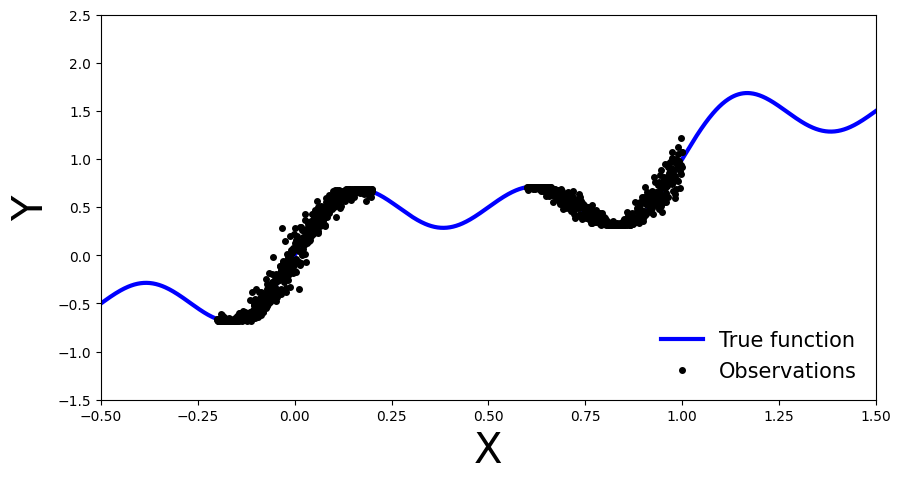

In [6]:


# Set random seed for reproducibility
np.random.seed(42)

# Generate data
x_obs = np.hstack([np.linspace(-0.2, 0.2, 500), np.linspace(0.6, 1, 500)])
noise = 0.02 * np.random.randn(x_obs.shape[0])
y_obs = x_obs + 0.3 * np.sin(2 * np.pi * (x_obs + noise)) + 0.3 * np.sin(4 * np.pi * (x_obs + noise)) + noise

x_true = np.linspace(-0.5, 1.5, 1000)
y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)

# Set plot limits and labels
xlims = [-0.5, 1.5]
ylims = [-1.5, 2.5]

# Create plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_true, y_true, 'b-', linewidth=3, label="True function")
ax.plot(x_obs, y_obs, 'ko', markersize=4, label="Observations")
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel("X", fontsize=30)
ax.set_ylabel("Y", fontsize=30)
ax.legend(loc=4, fontsize=15, frameon=False)

plt.show()



In [48]:
x_obs

array([-2.00000000e-01, -1.99198397e-01, -1.98396794e-01, -1.97595190e-01,
       -1.96793587e-01, -1.95991984e-01, -1.95190381e-01, -1.94388778e-01,
       -1.93587174e-01, -1.92785571e-01, -1.91983968e-01, -1.91182365e-01,
       -1.90380762e-01, -1.89579158e-01, -1.88777555e-01, -1.87975952e-01,
       -1.87174349e-01, -1.86372745e-01, -1.85571142e-01, -1.84769539e-01,
       -1.83967936e-01, -1.83166333e-01, -1.82364729e-01, -1.81563126e-01,
       -1.80761523e-01, -1.79959920e-01, -1.79158317e-01, -1.78356713e-01,
       -1.77555110e-01, -1.76753507e-01, -1.75951904e-01, -1.75150301e-01,
       -1.74348697e-01, -1.73547094e-01, -1.72745491e-01, -1.71943888e-01,
       -1.71142285e-01, -1.70340681e-01, -1.69539078e-01, -1.68737475e-01,
       -1.67935872e-01, -1.67134269e-01, -1.66332665e-01, -1.65531062e-01,
       -1.64729459e-01, -1.63927856e-01, -1.63126253e-01, -1.62324649e-01,
       -1.61523046e-01, -1.60721443e-01, -1.59919840e-01, -1.59118236e-01,
       -1.58316633e-01, -

In [85]:
# Convert data arrays to PyTorch tensors
x_train = torch.from_numpy(x_obs).float()
y_train = torch.from_numpy(y_obs).float()

In [86]:
x_train

tensor([-2.0000e-01, -1.9920e-01, -1.9840e-01, -1.9760e-01, -1.9679e-01,
        -1.9599e-01, -1.9519e-01, -1.9439e-01, -1.9359e-01, -1.9279e-01,
        -1.9198e-01, -1.9118e-01, -1.9038e-01, -1.8958e-01, -1.8878e-01,
        -1.8798e-01, -1.8717e-01, -1.8637e-01, -1.8557e-01, -1.8477e-01,
        -1.8397e-01, -1.8317e-01, -1.8236e-01, -1.8156e-01, -1.8076e-01,
        -1.7996e-01, -1.7916e-01, -1.7836e-01, -1.7756e-01, -1.7675e-01,
        -1.7595e-01, -1.7515e-01, -1.7435e-01, -1.7355e-01, -1.7275e-01,
        -1.7194e-01, -1.7114e-01, -1.7034e-01, -1.6954e-01, -1.6874e-01,
        -1.6794e-01, -1.6713e-01, -1.6633e-01, -1.6553e-01, -1.6473e-01,
        -1.6393e-01, -1.6313e-01, -1.6232e-01, -1.6152e-01, -1.6072e-01,
        -1.5992e-01, -1.5912e-01, -1.5832e-01, -1.5752e-01, -1.5671e-01,
        -1.5591e-01, -1.5511e-01, -1.5431e-01, -1.5351e-01, -1.5271e-01,
        -1.5190e-01, -1.5110e-01, -1.5030e-01, -1.4950e-01, -1.4870e-01,
        -1.4790e-01, -1.4709e-01, -1.4629e-01, -1.4

In [7]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn

In [155]:
class BNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=10, n_hid_layers=5, prior_scale=5.):
        super().__init__()

        self.activation = nn.Tanh()  # could also be ReLU or LeakyReLU
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        mu = self.layers[-1](x).squeeze()  # hidden --> output
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # infer the response noise

        # print("mu shape:", mu.shape)
        # print("sigma shape:", sigma.shape)
        # print("y shape:", y.shape)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)

        
        return mu

In [132]:
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from tqdm.auto import trange
pyro.clear_param_store()

model = BNN(hid_dim=10, n_hid_layers=5, prior_scale=5.)
mean_field_guide = AutoDiagonalNormal(model)
optimizer = pyro.optim.Adam({"lr": 0.01})

svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 250
progress_bar = trange(num_epochs)


losses = []
for epoch in progress_bar:
    loss = svi.step(x_train, y_train)
    avg_loss = loss / x_train.shape[0]
    losses.append(avg_loss)
    progress_bar.set_postfix(loss=f"{loss / x_train.shape[0]:.3f}")

  0%|          | 0/250 [00:00<?, ?it/s]

mu shape: torch.Size([2400])
sigma shape: torch.Size([])
y shape: torch.Size([2400])
mu shape: torch.Size([2400])
sigma shape: torch.Size([])
y shape: torch.Size([2400])


ValueError: Error while computing log_prob at site 'obs':
Expected value argument (Tensor of shape (2400,)) to be within the support (Real()) of the distribution Normal(loc: torch.Size([2400]), scale: torch.Size([2400])), but found invalid values:
tensor([ 5.9147, 49.7753, 83.2111,  ..., 31.0862, 18.7689, 16.2718])
       Trace Shapes:             
        Param Sites:             
       Sample Sites:             
layers.0.weight dist      | 10  1
               value      | 10  1
            log_prob      |      
  layers.0.bias dist      | 10   
               value      | 10   
            log_prob      |      
       0.weight dist      | 10 10
               value      | 10 10
            log_prob      |      
         0.bias dist      | 10   
               value      | 10   
            log_prob      |      
       1.weight dist      | 10 10
               value      | 10 10
            log_prob      |      
         1.bias dist      | 10   
               value      | 10   
            log_prob      |      
       2.weight dist      | 10 10
               value      | 10 10
            log_prob      |      
         2.bias dist      | 10   
               value      | 10   
            log_prob      |      
       3.weight dist      | 10 10
               value      | 10 10
            log_prob      |      
         3.bias dist      | 10   
               value      | 10   
            log_prob      |      
layers.5.weight dist      |  1 10
               value      |  1 10
            log_prob      |      
  layers.5.bias dist      |  1   
               value      |  1   
            log_prob      |      
          sigma dist      |      
               value      |      
            log_prob      |      
            obs dist 2400 |      
               value 2400 |      

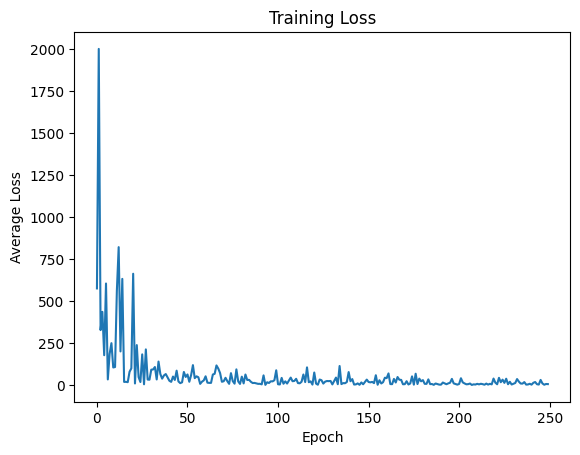

In [43]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.show()

In [44]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=mean_field_guide, num_samples=500)
preds = predictive(x_test)




In [45]:
def plot_predictions(preds):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    xlims = [-0.5, 1.5]
    ylims = [-1.5, 2.5]
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    ax.plot(x_obs, y_obs, 'ko', markersize=4, label="observations")
    ax.plot(x_obs, y_obs, 'ko', markersize=3)
    ax.plot(x_test, y_pred, '-', linewidth=3, color="#408765", label="predictive mean")
    ax.fill_between(x_test, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

    plt.legend(loc=4, fontsize=15, frameon=False)



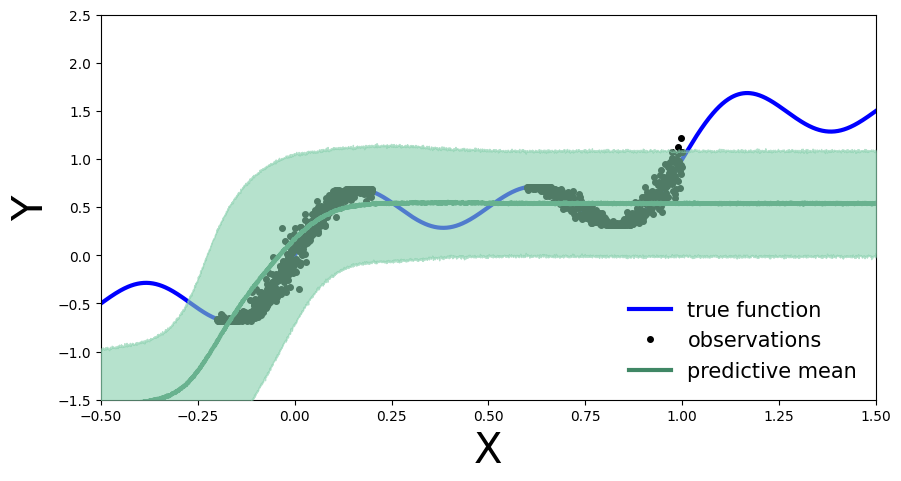

In [46]:
plot_predictions(preds)



#### With my own data

In [257]:
# import data
import pandas as pd
x_names=['L','b1']
y_names=['sf3']
data=pd.concat([pd.read_csv("TestData\\5_CFBSamples.csv")[x_names], pd.read_csv("TestData\\SumRes_5.csv")[y_names]], axis=1)
print(data.head())
data.dropna(axis=0,inplace=True)
x_data=data[x_names]
x_tensor = torch.tensor(x_data.values).float().squeeze()
y_data=data[y_names]
y_tensor = torch.tensor(y_data.values).float().squeeze()
# x_tensor[x_tensor.isnan()=='None']
# x_tensor[0].type()

       L     b1        sf3
0   4022  34617  36.718483
1   7396  21146  32.235802
2   9413   8674  12.078222
3  15649  14750  40.220158
4  15346  15945   0.000000


In [251]:
data

,L,b1,sf3
0,4022,34617,36.718483
1,7396,21146,32.235802
2,9413,8674,12.078222
3,15649,14750,40.220158
4,15346,15945,0.000000
...,...,...,...
2995,8110,8070,0.000000
2996,15365,22237,71.670128
2997,8975,18353,6.320156
2998,8191,11945,6.310112


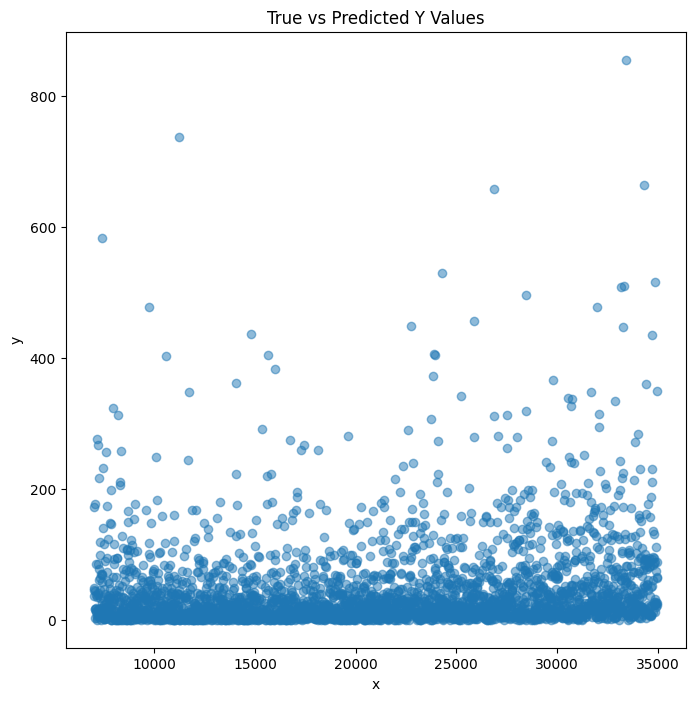

In [258]:
# Plot true vs predicted values
plt.figure(figsize=(8, 8))
plt.scatter(x_data['b1'], y_data, alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('True vs Predicted Y Values')
#plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')  # Perfect predictions line
plt.show()

In [259]:
# train, test split

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_tensor, y_tensor, test_size=0.2, random_state=42)
#x_train = x_train.reshape(-1, 1)
#y_train = y_train.reshape(-1, 1)
print(x_train.shape)

print(x_train)
print(y_train)

torch.Size([2395, 2])
tensor([[ 6172., 14126.],
        [11701., 12123.],
        [10511., 14615.],
        ...,
        [ 3513., 27485.],
        [ 8811.,  8007.],
        [ 7248., 25500.]])
tensor([35.2829, 73.2931,  0.0000,  ..., 10.9237, 40.7451, 12.3410])


In [230]:
if torch.isnan(x_train).any() or torch.isnan(y_train).any():
    print("NaN values found in tensors")

# Find indices where either x_train or y_train has NaN values
nan_indices = torch.isnan(x_train) | torch.isnan(y_train)

# Invert the nan_indices to get indices of non-NaN values
non_nan_indices = ~nan_indices

# Filter out the samples with NaN values from both x_train and y_train
x_train = x_train[non_nan_indices]
y_train = y_train[non_nan_indices]

if torch.isnan(x_train).any() or torch.isnan(y_train).any():
    print("NaN values found in tensors")




if torch.isnan(x_val).any() or torch.isnan(y_val).any():
    print("NaN values found in tensors")

# Find indices where either x_train or y_train has NaN values
nan_indices = torch.isnan(x_val) | torch.isnan(y_val)

# Invert the nan_indices to get indices of non-NaN values
non_nan_indices = ~nan_indices

# Filter out the samples with NaN values from both x_train and y_train
x_val = x_val[non_nan_indices]
y_val = y_val[non_nan_indices]

if torch.isnan(x_val).any() or torch.isnan(y_val).any():
    print("NaN values found in tensors")

print(y_train.shape)

print(y_val.shape)

RuntimeError: The size of tensor a (4796) must match the size of tensor b (2396) at non-singleton dimension 0

In [162]:
mean = x_train.mean(dim=0)
print(mean)
std = x_train.std(dim=0)
print(std)

tensor(9731.2246)
tensor(3604.8220)


In [129]:
# # Normalisation

# mean = x_train.mean(dim=0)
# std = x_train.std(dim=0)

# x_train_normalized = (x_train - mean) / std
# x_val_normalized = (x_val - mean) / std

# # Handling potential division by zero if a feature has constant value (std = 0)
# x_train_normalized[torch.isnan(x_train_normalized)] = 0
# x_val_normalized[torch.isnan(x_val_normalized)] = 0

In [260]:
class BNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=10, n_hid_layers=5, prior_scale=5.):
        super().__init__()

        self.activation = nn.Tanh()  # could also be ReLU or LeakyReLU
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        # x = x.reshape(-1, 1)
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        mu = self.layers[-1](x).squeeze()  # hidden --> output
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # infer the response noise

        # print("mu shape:", mu.shape)
        # print("sigma shape:", sigma.shape)
        # print("y shape:", y.shape)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)

        
        return mu

In [261]:
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from tqdm.auto import trange
pyro.clear_param_store()

model = BNN(in_dim=2, out_dim=1, hid_dim=10, n_hid_layers=5, prior_scale=5.)
mean_field_guide = AutoDiagonalNormal(model)
optimizer = pyro.optim.Adam({"lr": 0.01})

svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 250
progress_bar = trange(num_epochs)


losses = []
for epoch in progress_bar:
    loss = svi.step(x_train, y_train)
    avg_loss = loss / x_train.shape[0]
    losses.append(avg_loss)
    progress_bar.set_postfix(loss=f"{loss / x_train.shape[0]:.3f}")

  0%|          | 0/250 [00:00<?, ?it/s]

In [268]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=mean_field_guide, num_samples=500)
preds = predictive(x_val)

In [264]:
preds['obs']

tensor([[13.6936, 13.9883, 13.6459,  ..., 13.7941, 13.8574, 13.8997],
        [13.7668, 13.8163, 13.7284,  ..., 13.9011, 13.7235, 13.6995],
        [13.5597, 13.9499, 13.5971,  ..., 13.3351, 13.6239, 13.5124],
        ...,
        [13.8074, 13.8881, 14.0816,  ..., 13.9447, 14.0108, 13.7655],
        [13.4443, 13.3816, 13.4877,  ..., 13.5992, 13.3799, 13.5370],
        [13.9069, 13.6710, 13.7818,  ..., 13.8749, 13.6727, 13.7111]])

In [263]:
predicted_y_mean = preds['obs'].mean(0)
predicted_y_mean

tensor([13.7831, 13.7776, 13.7813, 13.7839, 13.7742, 13.7912, 13.7913, 13.7697,
        13.7770, 13.7794, 13.7786, 13.7771, 13.7777, 13.7836, 13.7878, 13.7755,
        13.7786, 13.7824, 13.7838, 13.7791, 13.7740, 13.7748, 13.7818, 13.7784,
        13.7765, 13.7740, 13.7882, 13.7762, 13.7840, 13.7827, 13.7796, 13.7687,
        13.7824, 13.7772, 13.7863, 13.7782, 13.7769, 13.7802, 13.7777, 13.7799,
        13.7817, 13.7680, 13.7818, 13.7867, 13.7613, 13.7744, 13.7802, 13.7870,
        13.7840, 13.7823, 13.7835, 13.7739, 13.7801, 13.7905, 13.7730, 13.7874,
        13.7727, 13.7793, 13.7795, 13.7715, 13.7826, 13.7815, 13.7755, 13.7776,
        13.7710, 13.7806, 13.7832, 13.7800, 13.7855, 13.7740, 13.7780, 13.7837,
        13.7772, 13.7849, 13.7760, 13.7783, 13.7828, 13.7730, 13.7882, 13.7871,
        13.7816, 13.7784, 13.7891, 13.7726, 13.7769, 13.7839, 13.7737, 13.7804,
        13.7762, 13.7786, 13.7787, 13.7885, 13.7836, 13.7844, 13.7815, 13.7868,
        13.7781, 13.7803, 13.7842, 13.78

In [269]:
# y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
# print(y_pred)
y_pred= preds['obs'][0]
print(y_pred)

tensor([14.0023, 13.8011, 13.7345, 13.9289, 14.1002, 14.0312, 13.9041, 14.0293,
        14.0565, 14.1177, 13.8500, 13.9890, 14.0189, 14.0004, 13.9295, 13.9360,
        14.1566, 14.0353, 13.9395, 13.9589, 13.7793, 14.0803, 13.8825, 13.8970,
        13.9577, 14.0389, 13.8536, 14.0981, 13.8777, 14.0158, 14.0840, 14.1094,
        13.8735, 13.9710, 13.9207, 13.8279, 14.0040, 13.9768, 14.1377, 13.9560,
        14.0905, 14.0761, 14.0048, 13.8791, 13.9823, 13.9109, 13.9583, 13.9216,
        13.9050, 13.9729, 14.0721, 14.0793, 13.9840, 13.9814, 13.9034, 14.0185,
        13.8080, 13.9564, 14.0047, 13.8129, 14.0024, 13.9415, 14.0092, 14.0136,
        13.8592, 13.9833, 14.0118, 14.0790, 13.9245, 14.0718, 14.1334, 13.9372,
        13.9383, 14.0667, 14.0658, 13.9483, 13.8873, 13.9046, 13.8730, 13.7721,
        13.9908, 13.9311, 14.0306, 13.9599, 13.9400, 14.1543, 14.0784, 14.0802,
        13.9548, 14.0562, 13.9204, 13.9036, 14.1299, 13.9239, 13.9756, 14.0181,
        13.8090, 13.8285, 13.8402, 13.89

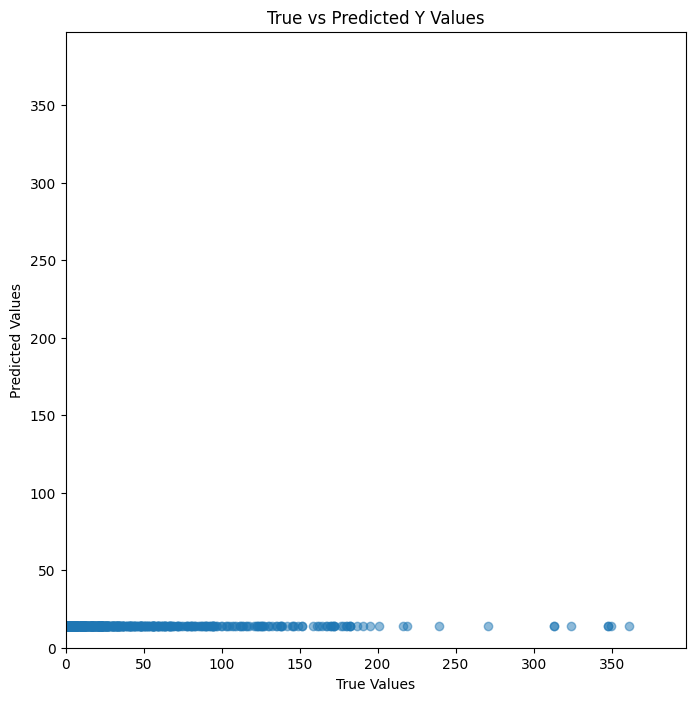

In [265]:
# Plot true vs predicted values
plt.figure(figsize=(8, 8))
plt.scatter(y_val, predicted_y_mean, alpha=0.5)
max_value = max(y_val.max(), predicted_y_mean.max())
min_value = min(y_val.min(), predicted_y_mean.min())
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Y Values')
plt.xlim(-0.1 * min_value, 1.1 * max_value)
plt.ylim(-0.1 * min_value, 1.1 * max_value)
#plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')  # Perfect predictions line
plt.show()

In [270]:
#Assuming y_val and y_pred are PyTorch tensors
# Calculate the squared differences
squared_diff = (y_val - y_pred) ** 2

# Calculate the mean of squared differences
mean_squared_diff = torch.mean(squared_diff)

# Calculate RMSE
rmse = torch.sqrt(mean_squared_diff)

print("Root Mean Squared Error (RMSE):", rmse.item())

Root Mean Squared Error (RMSE): 63.82502746582031


In [189]:
def plot_predictions(preds):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    # xlims = [-0.5, 1.5]
    # ylims = [-1.5, 2.5]
    # plt.xlim(xlims)
    # plt.ylim(ylims)
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    ax.plot(x_train, y_train, 'ko', markersize=4, label="observations")
    ax.plot(x_train, y_train, 'ko', markersize=3)
    ax.plot(x_val, y_pred, '-', linewidth=3, color="#408765", label="predictive mean")
    ax.fill_between(x_val, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

    plt.legend(loc=4, fontsize=15, frameon=False)

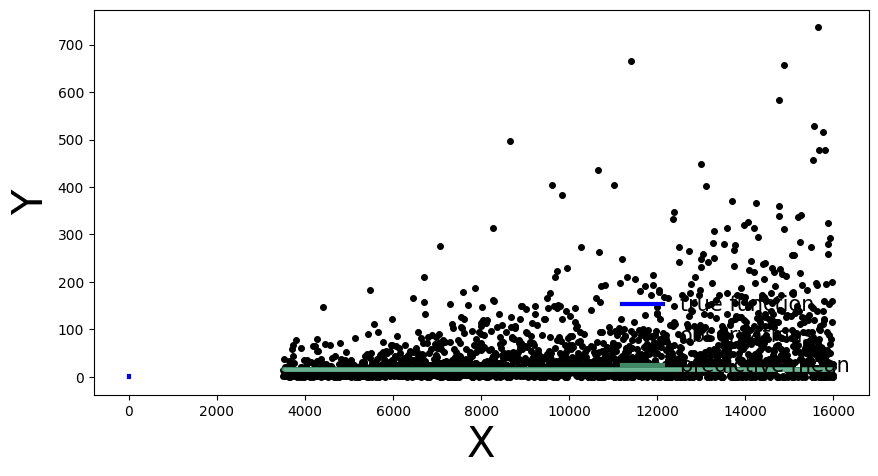

In [190]:
plot_predictions(preds)

In [1]:
### Chat GPT implementation using pyro

In [ ]:
import torch
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from sklearn.preprocessing import StandardScaler

# Generate synthetic dataset (reuse the function from the previous TensorFlow example)

# Generate synthetic dataset
def generate_synthetic_data(n_samples=1000):
    X = np.linspace(-3, 3, n_samples)
    y = np.sin(X) + np.random.normal(0, 0.2, n_samples)  # Adding some noise
    return X.reshape(-1, 1), y

X, y = generate_synthetic_data()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Data preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float)

# Bayesian neural network model
class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[torch.nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

# Initialize the model and guide
model = BayesianRegression(1, 1)
guide = pyro.infer.autoguide.AutoDiagonalNormal(model)

# Optimizer and loss function
optimizer = Adam({"lr": 0.03})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_iterations = 1000
for j in range(num_iterations):
    # Calculate the loss and take a gradient step
    loss = svi.step(X_train_tensor, y_train_tensor)
    if j % 100 == 0:
        print(f"Epoch {j} : loss = {loss}")

# Make predictions (posterior samples)
predictive = pyro.infer.Predictive(model, guide=guide, num_samples=1000, return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(X_test_tensor)
y_pred = samples["_RETURN"].mean(0).detach().numpy()

# Plot predictions (reuse the plotting code from the TensorFlow example)
# Plot predictions
plt.scatter(X_train, y_train, label="Training data")
plt.scatter(X_test, y_test, color="r", label="Testing data")
plt.scatter(X_test, y_pred, color="g", label="BNN Predictions")
plt.legend()
plt.title("BNN Predictions on Synthetic Dataset")
plt.xlabel("Input Feature")
plt.ylabel("Target Variable")
plt.show()


In [97]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import math

## SBB Database

In [98]:
# Import data
data = pd.read_csv('HL_SBB.csv',delimiter=";")
print(data.shape)
data.head()

(9411, 25)


,NewID,Source,Source ID,Name,Year built,Country,Region,Latitude,Longitude,Topology,...,Total length [m],Width [m],max span [m],avg height [m],Deck depth [m],Status,Deck Condition,Superstructure Condition,Substructure Condition,Unnamed: 24
0,5000,SBB,6586d5a0-0a95-11e8-8b02-fb3b4701752b,Bru Tun. à bagages nord,1962.0,Switzerland,Lausanne,NaN,NaN,geschlossener Rahmen,...,3.70,236.00,3.70,2.90,0.30,Bestehend,NaN,NaN,NaN,NaN
1,5001,SBB,fd503e10-0a91-11e8-8b02-fb3b4701752b,Bru Tunnel à bagages sud,1962.0,Switzerland,Lausanne,NaN,NaN,geschlossener Rahmen,...,3.70,237.00,3.70,2.90,0.30,Bestehend,NaN,NaN,NaN,NaN
2,5002,SBB,cb1474fd-0a95-11e8-8b02-fb3b4701752b,Bru Pt mur voûte sud/o1,1908.0,Switzerland,Lausanne,NaN,NaN,Bogen oder Gewölbe,...,61.60,4.04,5.60,5.00,0.60,Bestehend,NaN,NaN,NaN,NaN
3,5003,SBB,c3300a5f-0a95-11e8-8b02-fb3b4701752b,Bru Pt du Lausanne-Ouchy,1911.0,Switzerland,Lausanne,NaN,NaN,Bogen oder Gewölbe,...,6.50,129.37,6.50,5.40,0.70,Bestehend,NaN,NaN,NaN,NaN
4,5004,SBB,a2ff88bb-0a95-11e8-8b02-fb3b4701752b,Bru Pt mur-voûte S/E P.1,1900.0,Switzerland,Lausanne,NaN,NaN,Bogen oder Gewölbe,...,32.93,5.90,3.94,5.72,0.55,Bestehend,NaN,NaN,NaN,NaN


#### Preprocessing: Data selection

In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9411 entries, 0 to 9410
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   NewID                     9411 non-null   int64  
 1   Source                    9411 non-null   object 
 2   Source ID                 9411 non-null   object 
 3   Name                      9411 non-null   object 
 4   Year built                9394 non-null   float64
 5   Country                   9411 non-null   object 
 6   Region                    9407 non-null   object 
 7   Latitude                  0 non-null      float64
 8   Longitude                 0 non-null      float64
 9   Topology                  9378 non-null   object 
 10  Service on bridge         9408 non-null   object 
 11  Service under bridge      9406 non-null   object 
 12  Main material             9394 non-null   object 
 13  Pier Material             0 non-null      float64
 14  Deck Mat

In [100]:
#count number of missing data per column
data.isnull().sum()

NewID                          0
Source                         0
Source ID                      0
Name                           0
Year built                    17
Country                        0
Region                         4
Latitude                    9411
Longitude                   9411
Topology                      33
Service on bridge              3
Service under bridge           5
Main material                 17
Pier Material               9411
Deck Material                 36
Total length [m]              55
Width [m]                     32
max span [m]                  93
avg height [m]                87
Deck depth [m]               197
Status                         0
Deck Condition              9411
Superstructure Condition    9411
Substructure Condition      9411
Unnamed: 24                 9411
dtype: int64

In [101]:
# missing data percentage list
for col in data.columns:
    missing = np.mean(data[col].isnull())
    print('{} - {}%'.format(col, round(missing*100,2)))

NewID - 0.0%
Source - 0.0%
Source ID - 0.0%
Name - 0.0%
Year built - 0.18%
Country - 0.0%
Region - 0.04%
Latitude - 100.0%
Longitude - 100.0%
Topology - 0.35%
Service on bridge - 0.03%
Service under bridge - 0.05%
Main material - 0.18%
Pier Material - 100.0%
Deck Material - 0.38%
Total length [m] - 0.58%
Width [m] - 0.34%
max span [m] - 0.99%
avg height [m] - 0.92%
Deck depth [m] - 2.09%
Status - 0.0%
Deck Condition - 100.0%
Superstructure Condition - 100.0%
Substructure Condition - 100.0%
Unnamed: 24 - 100.0%


<Axes: >

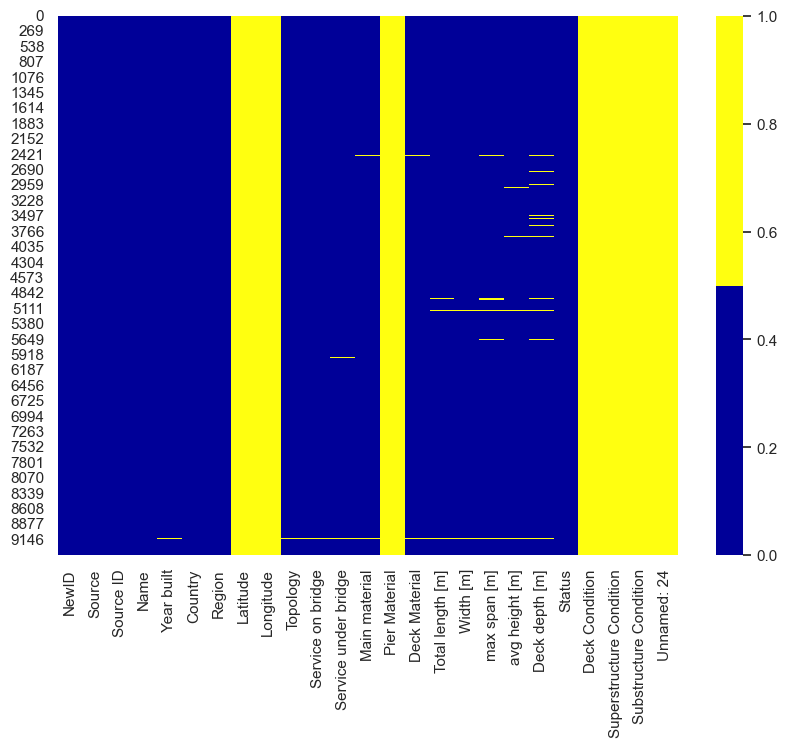

In [102]:
# using a heat map to visualize missing data
cols = data.columns # first 30 columns
colours = ['#000098', '#ffff10'] # specify the colours - yellow is missing. blue is not missing.

fig, ax = plt.subplots(figsize=(10,7)) 
sns.heatmap(data[cols].isnull(), cmap=sns.color_palette(colours), ax=ax)

In [103]:
# replacing invalid values
data.replace('Unknown', np.nan, inplace=True)
data.replace(' ', np.nan, inplace=True)
data.replace('none', np.nan, inplace=True)

In [104]:
#remove rows that have no topology
data.dropna(subset=['Topology'],inplace=True)
# missing data percentage list
for col in data.columns:
    missing = np.mean(data[col].isnull())
    print('{} - {}%'.format(col, round(missing*100,2)))

NewID - 0.0%
Source - 0.0%
Source ID - 0.0%
Name - 0.0%
Year built - 0.1%
Country - 0.0%
Region - 0.04%
Latitude - 100.0%
Longitude - 100.0%
Topology - 0.0%
Service on bridge - 0.01%
Service under bridge - 0.03%
Main material - 0.03%
Pier Material - 100.0%
Deck Material - 0.21%
Total length [m] - 0.31%
Width [m] - 0.1%
max span [m] - 0.71%
avg height [m] - 0.64%
Deck depth [m] - 1.78%
Status - 0.0%
Deck Condition - 100.0%
Superstructure Condition - 100.0%
Substructure Condition - 100.0%
Unnamed: 24 - 100.0%


In [105]:
data['Topology'].value_counts()

Topology
Einfeldträger           3709
geschlossener Rahmen    1741
Bogen oder Gewölbe      1319
Durchlaufträger         1219
offener Rahmen           975
Einfeldfolge             194
Rohr oder Maulprofil     121
Sprengwerk                38
Sondertyp                 27
Doppelgelenkrahmen        17
Bowstring                 12
Schrägseilbrücke           1
Name: count, dtype: int64

In [106]:
pd.unique(data['Topology'])

array(['geschlossener Rahmen', 'Bogen oder Gewölbe', 'Einfeldträger',
       'Durchlaufträger', 'Sprengwerk', 'offener Rahmen', 'Einfeldfolge',
       'Bowstring', 'Sondertyp', 'Rohr oder Maulprofil',
       'Doppelgelenkrahmen', 'Schrägseilbrücke'], dtype=object)

In [107]:
# Trandsationg typologies and unify the names with other data bases
#data.loc[data['Topology'] == 'Brücke\xa0mit\xa0Durchlaufträger', 'Topology'] = 'Girder bridge'

data['Topology'] = data['Topology'].replace('geschlossener Rahmen', 'Frame (closed)')
data['Topology'] = data['Topology'].replace('Bogen oder Gewölbe', 'Arch')
data['Topology'] = data['Topology'].replace('Einfeldträger', 'Girder (single span)')
data['Topology'] = data['Topology'].replace('Durchlaufträger', 'Girder (continuous)')
data['Topology'] = data['Topology'].replace('Sprengwerk', 'Sprengwerk')
data['Topology'] = data['Topology'].replace('offener Rahmen', 'Frame (open)')
data['Topology'] = data['Topology'].replace('Einfeldfolge', 'Girder (single span)')
data['Topology'] = data['Topology'].replace('Bowstring', 'Tired-Arch')
data['Topology'] = data['Topology'].replace('Sondertyp', 'Other')
data['Topology'] = data['Topology'].replace('Rohr oder Maulprofil', 'Pipeprofiles')
data['Topology'] = data['Topology'].replace('Doppelgelenkrahmen', 'Frame (double jointed)')
data['Topology'] = data['Topology'].replace('Schrägseilbrücke', 'Cable-stayed')


In [108]:
data['Topology unified']=data['Topology']


data['Topology unified'] = data['Topology unified'].replace('Frame (closed)', 'Frame')
data['Topology unified'] = data['Topology unified'].replace('Girder (single span)', 'Girder')
data['Topology unified'] = data['Topology unified'].replace( 'Girder (continuous)','Girder')
data['Topology unified'] = data['Topology unified'].replace('Frame (open)','Frame')
data['Topology unified'] = data['Topology unified'].replace('Girder (single span)','Girder')
data['Topology unified'] = data['Topology unified'].replace( 'Frame (double jointed)','Other')


data.to_csv('HL_SBB_pp.csv', index=False)


In [109]:
pd.unique(data['Topology unified'])

array(['Frame', 'Arch', 'Girder', 'Sprengwerk', 'Tired-Arch', 'Other',
       'Pipeprofiles', 'Cable-stayed'], dtype=object)

Rectangle(xy=(0, -0.4), width=2716, height=0.8, angle=0)
Rectangle(xy=(0, 0.6), width=1319, height=0.8, angle=0)
Rectangle(xy=(0, 1.6), width=5122, height=0.8, angle=0)
Rectangle(xy=(0, 2.6), width=38, height=0.8, angle=0)
Rectangle(xy=(0, 3.6), width=12, height=0.8, angle=0)
Rectangle(xy=(0, 4.6), width=44, height=0.8, angle=0)
Rectangle(xy=(0, 5.6), width=121, height=0.8, angle=0)
Rectangle(xy=(0, 6.6), width=1, height=0.8, angle=0)


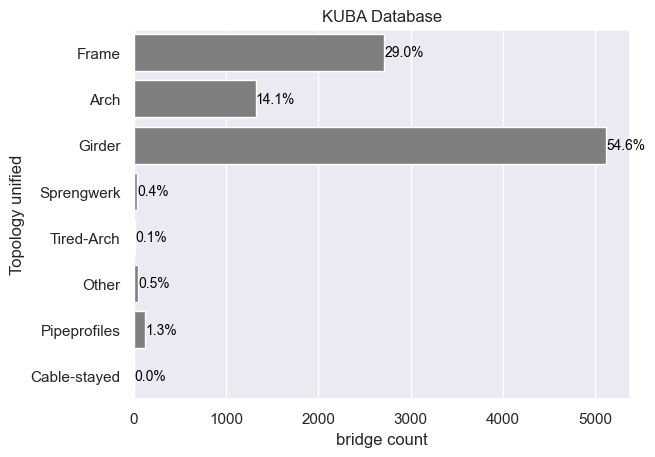

In [110]:
sns.set(style="darkgrid")
ax =sns.countplot(y='Topology unified', data=data, color='tab:gray')
plt.title('KUBA Database')
ax.set_xlabel('bridge count')#, fontsize=18)

# Add percentages to the plot
total = len(data['Topology'])
for p in ax.patches:
    print(p)
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    
    #ax.annotate(percentage, (x, y), ha='left')
    ax.text(x, y, percentage, ha='left', va='center', color='black', fontsize=10)

Rectangle(xy=(0, -0.4), width=1741, height=0.8, angle=0)
Rectangle(xy=(0, 0.6), width=1319, height=0.8, angle=0)
Rectangle(xy=(0, 1.6), width=3903, height=0.8, angle=0)
Rectangle(xy=(0, 2.6), width=1219, height=0.8, angle=0)
Rectangle(xy=(0, 3.6), width=38, height=0.8, angle=0)
Rectangle(xy=(0, 4.6), width=975, height=0.8, angle=0)
Rectangle(xy=(0, 5.6), width=12, height=0.8, angle=0)
Rectangle(xy=(0, 6.6), width=27, height=0.8, angle=0)
Rectangle(xy=(0, 7.6), width=121, height=0.8, angle=0)
Rectangle(xy=(0, 8.6), width=17, height=0.8, angle=0)
Rectangle(xy=(0, 9.6), width=1, height=0.8, angle=0)


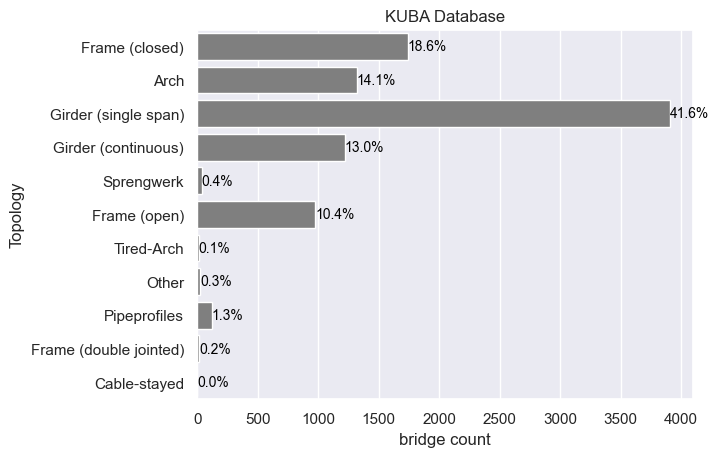

In [111]:
sns.set(style="darkgrid")
ax =sns.countplot(y='Topology', data=data, color='tab:gray')
plt.title('KUBA Database')
ax.set_xlabel('bridge count')#, fontsize=18)

# Add percentages to the plot
total = len(data['Topology'])
for p in ax.patches:
    print(p)
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    
    #ax.annotate(percentage, (x, y), ha='left')
    ax.text(x, y, percentage, ha='left', va='center', color='black', fontsize=10)



In [77]:
dataset = data[(data['max span [m]'].isnull()==False)]

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3235 entries, 0 to 4342
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   NewID                     3235 non-null   int64  
 1   Source                    3235 non-null   object 
 2   Source ID                 3235 non-null   object 
 3   Name                      3235 non-null   object 
 4   Year built                3217 non-null   float64
 5   Country                   3235 non-null   object 
 6   Region                    0 non-null      float64
 7   Landeskoordinaten E [m    3234 non-null   float64
 8   Landeskoordinaten N [m]   3234 non-null   float64
 9   Topology                  3235 non-null   object 
 10  Service on bridge         3235 non-null   object 
 11  Service under bridge      0 non-null      float64
 12  Main material             2879 non-null   object 
 13  Pier Material             0 non-null      float64
 14  Deck Material

array([[<Axes: title={'center': 'max span [m]'}>]], dtype=object)

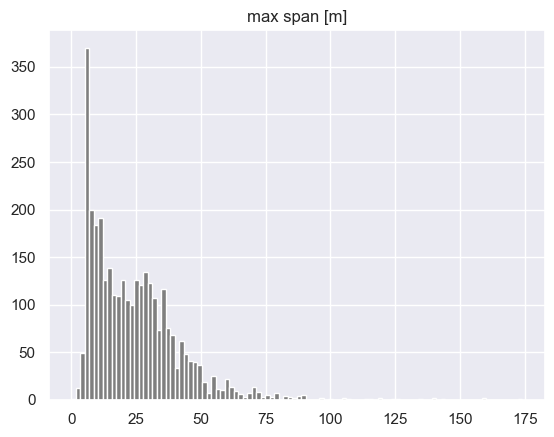

In [82]:
dataset.hist(column=['max span [m]'], bins=100, grid=True, color='tab:gray')#, figsize=[15,12], color='tab:gray')
# plt.title('KUBA Database')
# plt.xlabel('max span [m]')#, fontsize=18)
# plt.ylabel('bridge count')#, fontsize=18)

In [10]:
dataset.columns

Index(['NewID', 'Source', 'Source ID', 'Name', 'Year built', 'Country',
       'Region', 'Landeskoordinaten E [m', 'Landeskoordinaten N [m]',
       'Topology', 'Service on bridge', 'Service under bridge',
       'Main material', 'Pier Material', 'Deck Material', 'Total length [m]',
       'Width [m]', 'max span [m]', 'avg. hight [m]', 'Deck depth [m]',
       'Status', 'Deck Condition', 'Superstructure Condition',
       'Substructure Condition', 'Unnamed: 24'],
      dtype='object')

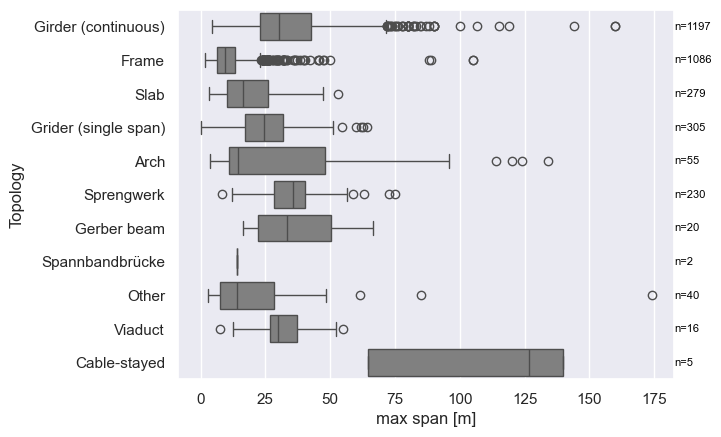

In [104]:
colors = ['black','tab:red','tab:blue','tab:green','tab:purple','tab:orange','tab:cyan','tab:pink','tab:olive','tab:brown','tab:gray']
# ax = sns.swarmplot(x=dataset['max span [m]'], y=dataset['Topology'], 
#                    hue=dataset['Main material'], palette=colors)
ax = sns.boxplot(x=dataset['max span [m]'], y=dataset['Topology'], color='gray')

# Calculate and add count annotations for each category
for i, label in enumerate(ax.get_yticklabels()):
    category = label.get_text()
    count = dataset['Topology'].value_counts()[category]
    
    # Position the annotation above the box
    x_pos = ax.get_xlim()[1] + 0.05
    y_pos = ax.get_yticks()[i]

    # Add the count annotation
    ax.text(x_pos, y_pos, f'n={count}', ha='left', va='center', color='black', fontsize=8)


plt.show()

In [94]:
dataset['Topology'].values

array(['Girder (continuous)', 'Frame', 'Frame', ..., 'Frame',
       'Grider (single span)', 'Frame'], dtype=object)

C:\Users\kuhnso\AppData\Local\Temp\ipykernel_18220\3407089436.py:3: UserWarning: 
The palette list has fewer values (11) than needed (12) and will cycle, which may produce an uninterpretable plot.
  ax = sns.swarmplot(x=dataset['max span [m]'], y=dataset['Topology'],
c:\Users\kuhnso\AppData\Local\anaconda3\envs\designPriors\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 20.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\kuhnso\AppData\Local\anaconda3\envs\designPriors\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 54.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\kuhnso\AppData\Local\anaconda3\envs\designPriors\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 22.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripp

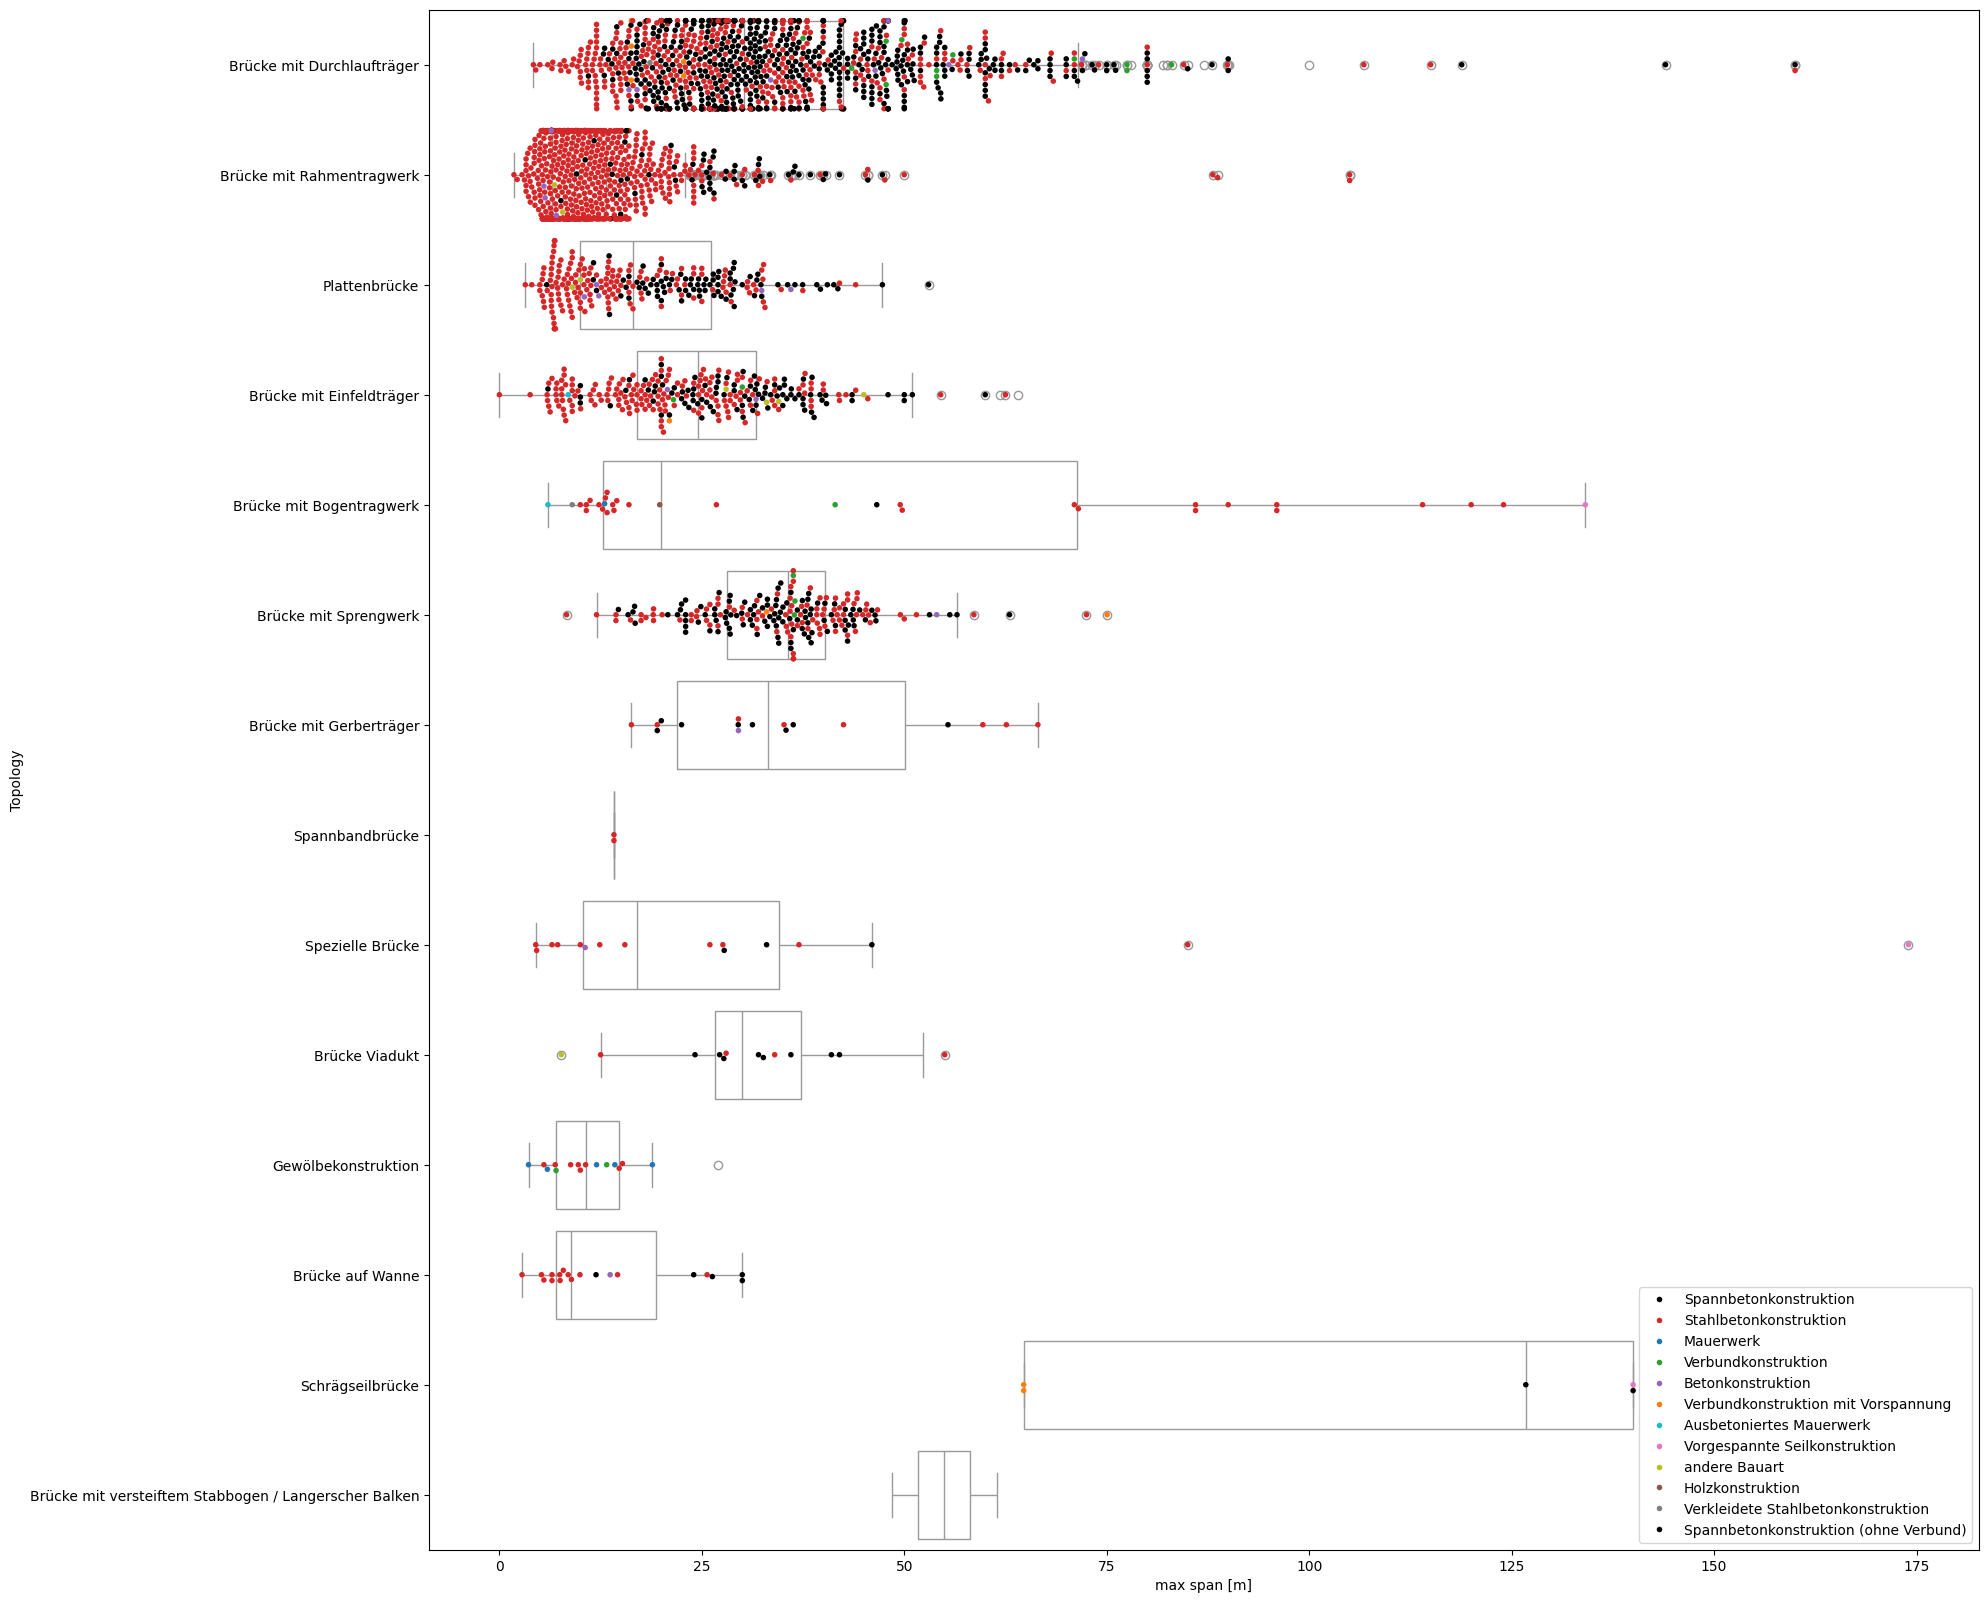

In [14]:
colors = ['black','tab:red','tab:blue','tab:green','tab:purple','tab:orange','tab:cyan','tab:pink','tab:olive','tab:brown','tab:gray']
plt.figure(figsize=(20,20))
ax = sns.swarmplot(x=dataset['max span [m]'], y=dataset['Topology'], 
                   hue=dataset['Main material'], palette=colors, s=4)
ax = sns.boxplot(x=dataset['max span [m]'], y=dataset['Topology'], color='white')

Text(0.5, 1.0, 'Rahmen')

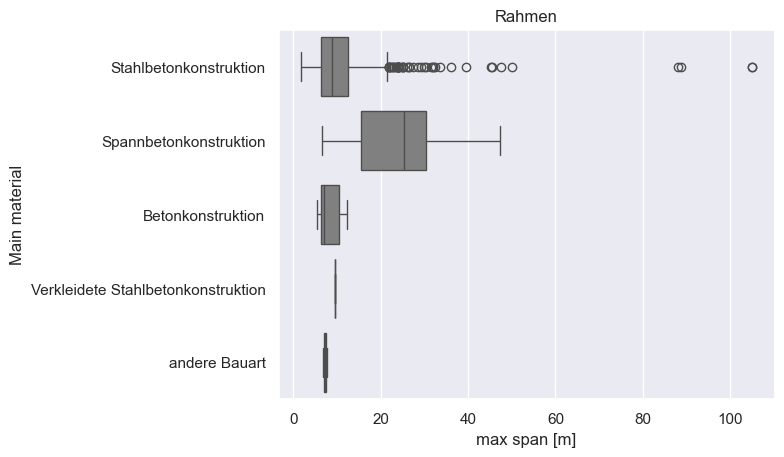

In [95]:
rahmen=dataset[dataset['Topology']=='Frame']
ax = sns.boxplot(x=rahmen['max span [m]'], y=rahmen['Main material'], color='gray')
plt.title('Rahmen')

C:\Users\kuhnso\AppData\Local\Temp\ipykernel_18220\154179284.py:3: UserWarning: 
The palette list has fewer values (11) than needed (12) and will cycle, which may produce an uninterpretable plot.
  ax = sns.swarmplot(x=rahmen['max span [m]'], y=rahmen['Topology'],
c:\Users\kuhnso\AppData\Local\anaconda3\envs\designPriors\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 36.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


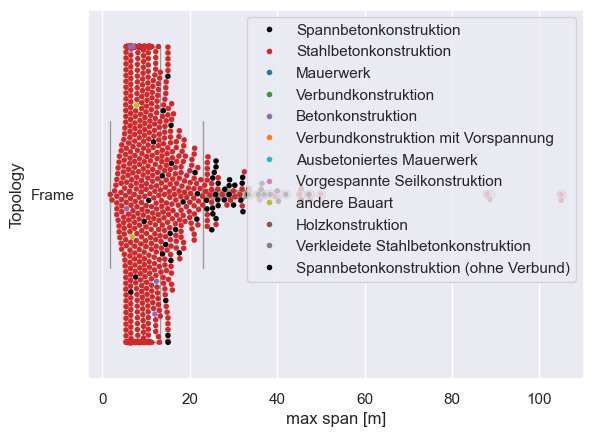

In [96]:
colors = ['black','tab:red','tab:blue','tab:green','tab:purple','tab:orange','tab:cyan','tab:pink','tab:olive','tab:brown','tab:gray']
#plt.figure(figsize=(20,20))
ax = sns.swarmplot(x=rahmen['max span [m]'], y=rahmen['Topology'], 
                   hue=dataset['Main material'], palette=colors, s=4)
ax = sns.boxplot(x=rahmen['max span [m]'], y=rahmen['Topology'], color='white')

In [97]:
# Plot relationships between parameters
markers = ['*', 's', '<', 'o', 'X', '8', 'p', 'h', 'H', 'D', 'd', 'P']
colors = ['black','tab:red','tab:blue','tab:green','tab:purple','tab:orange','tab:cyan','tab:pink','tab:olive','tab:brown','tab:gray']

# type_plot_2D()
def type_plot_2D(dataset, param_x, param_y, param_type):
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot() #aspect='equal'

    types = dataset.loc[:,param_type].unique()

    for i,j in enumerate(types):
        index = dataset.index[dataset.loc[:,param_type]==j]
        x = dataset.loc[index,param_x]
        y = dataset.loc[index,param_y]
        ax.scatter(x, y, c=colors[i], alpha=0.4, marker='.', s=80, label=types[i])

    ax.set_xlabel(param_x, fontsize=18)
    ax.set_ylabel(param_y, fontsize=18)
    ax.grid(True, color='0.75')
    plt.legend(fontsize=18)
    plt.title(param_type,fontsize=18)
# end: type_plot_2D()



In [98]:
rahmen['Deck depth [m]']

1      NaN
2      NaN
20     NaN
21     NaN
36     NaN
        ..
4308   NaN
4318   NaN
4334   NaN
4338   NaN
4342   NaN
Name: Deck depth [m], Length: 1086, dtype: float64

In [99]:
rahmen.columns

Index(['NewID', 'Source', 'Source ID', 'Name', 'Year built', 'Country',
       'Region', 'Landeskoordinaten E [m', 'Landeskoordinaten N [m]',
       'Topology', 'Service on bridge', 'Service under bridge',
       'Main material', 'Pier Material', 'Deck Material', 'Total length [m]',
       'Width [m]', 'max span [m]', 'avg. hight [m]', 'Deck depth [m]',
       'Status', 'Deck Condition', 'Superstructure Condition',
       'Substructure Condition', 'Unnamed: 24'],
      dtype='object')

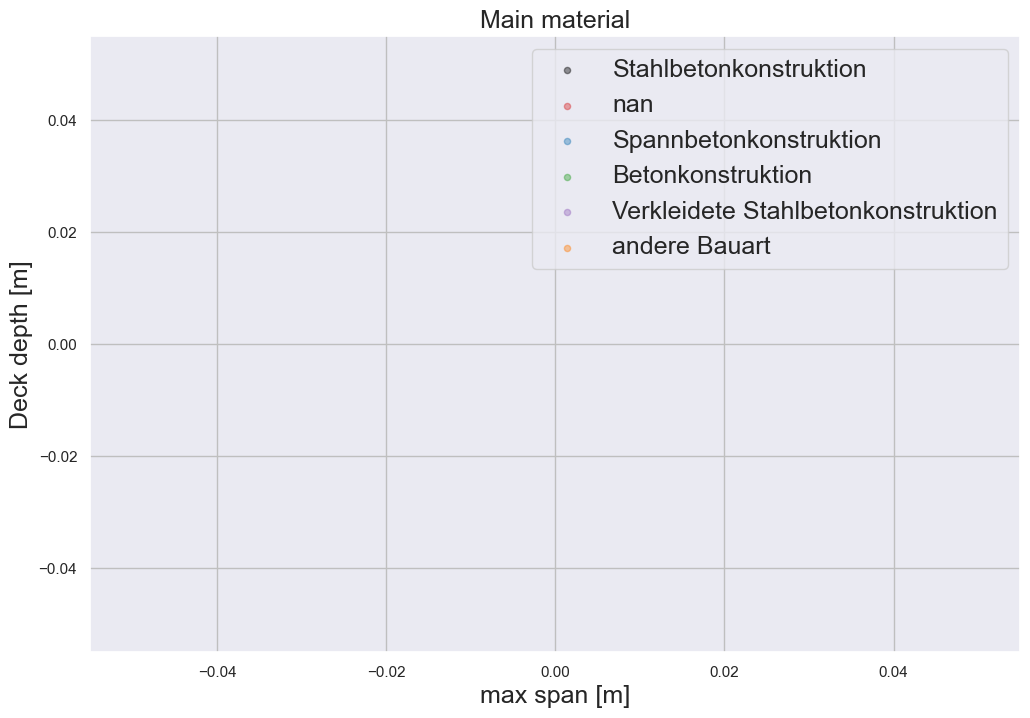

In [100]:
# Für geschlossene Rahmen sollte die Konstr-H der FB-Stärke entsprechen --> nicht immer der Fall
type_plot_2D(rahmen, 'max span [m]', 'Deck depth [m]', 'Main material')

In [68]:
# Drop columns
dataset = dataset.drop(columns=['IPID', #mit Index ersetzen
                                'Objektgruppe','Objektart','Lageart', #in Benutzung oben enthalten
                                'Bauart', #alle Beton
                                'Benutzung unten','Zweck Bahnzugang','Felder im Gleis','Bauwerkslänge','Länge im Gleis','Fläche im Gleis','Signalisierte H', #nicht relevant für Dimensionierung
                                #'Gesamtlänge im Licht', #nicht relevant für Dimensionierung
                                'Baujahr Unterbau', #zu wenig Daten, oft gleich wie Baujahr, aber: teilweise älterer UB
                                'Fahrbahnart', #Info Typ ausreichend
                                'Lage-FB','Lastbeschr','Vorsp-Produkt Nebenrichtung','Sonderfall Vorsp','Lagertyp', #zu wenig Daten
                                'Vorsp-Produkt Hauptrichtung', #Info Vorsp-Art ausreichend
                                'Gesamtfläche', #in Länge/Höhe enthalten
                                'Anz. FL-Schutz','Anz. Aufgänge','Anz. Nebenkonstr','Stahlgewicht','Anstrichsfl','GW-Wanne','Spez. Fund','Besonderheit2', #nicht relevant für Dimensionierung + zu wenig Daten
                                'Status']) #alle Bestehend
dataset = dataset.drop(columns=['Check L','Check LW','Check UB','Check FB']) #columns created in Excel

In [69]:
# Info
dataset.info()
print('Anzahl Kategorien: \n', dataset.select_dtypes('object').nunique())
print('Anzahl Nullwerte: \n', dataset.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1507 entries, 0 to 1506
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Typ                          1506 non-null   object 
 1   Benutzung oben               1506 non-null   object 
 2   Baujahr                      1504 non-null   float64
 3   J-Verstärkung                8 non-null      float64
 4   J-FB-Erneuerung              24 non-null     float64
 5   J-Verbreiterung              33 non-null     float64
 6   Anzahl Gleise                1499 non-null   float64
 7   Gleisbettung                 1504 non-null   object 
 8   Statisches System            1506 non-null   object 
 9   Lastbeschränkung Bahnbrücke  1449 non-null   object 
 10  Vorsp-Art                    1482 non-null   object 
 11  Winkel                       1500 non-null   float64
 12  Felder                       1502 non-null   float64
 13  Gesamtlänge       

In [70]:
# Typ => Datensatz reduzieren auf Betonplatte, Beton-Hohlkasten, Beton-Plattenbalken
dataset = dataset[(dataset['Typ']=='Betonplatte') | (dataset['Typ']=='Beton-Hohlkasten') | (dataset['Typ']=='Beton-Plattenbalken')] #Datensatz auf ausgewählte Typen reduzieren 
dataset = dataset.replace({'Betonplatte':'Slab',
                           'Beton-Hohlkasten':'Box girder',
                           'Beton-Plattenbalken':'Double-T girder'}) 
print(dataset['Typ'].unique())

['Slab' 'Box girder' 'Double-T girder']


In [71]:
# Benutzung oben => Datensatz reduzieren auf Streckengleis, Strasse, Personen
dataset = dataset.replace(to_replace=['Strasse','Nationalstrasse oder Zubringer','Weg'], value='Strasse/Weg') #Strassennutzungen zusammenfassen
dataset = dataset[(dataset['Benutzung oben']=='Streckengleis') | (dataset['Benutzung oben']=='Strasse/Weg') | (dataset['Benutzung oben']=='Personen')] #Datensatz auf ausgewählte Nutzungen reduzieren 
dataset = dataset.replace({'Streckengleis':'Rail',
                           'Strasse/Weg':'Road',
                           'Personen':'Pedestrian'})
print(dataset['Benutzung oben'].unique())

['Rail' 'Pedestrian' 'Road']


In [72]:
# Umbau => Neue Spalte
dataset.insert(dataset.columns.get_loc('Baujahr')+1,'Umbau','Original')

verstärkt = dataset.index[dataset['J-Verstärkung'].notnull()]
erneuert = dataset.index[dataset['J-FB-Erneuerung'].notnull()]
verbreitert = dataset.index[dataset['J-Verbreiterung'].notnull()]

dataset.loc[verstärkt,'Umbau'] = 'Reinforced'
dataset.loc[erneuert,'Umbau'] = 'New deck'
dataset.loc[verbreitert,'Umbau'] = 'Widened'

dataset = dataset.drop(columns=['J-Verstärkung','J-FB-Erneuerung','J-Verbreiterung']) 
print(dataset['Umbau'].unique())

['Original' 'New deck' 'Widened' 'Reinforced']


In [73]:
# Vorspannung
dataset = dataset.rename(columns={'Vorsp-Art':'Vorspannung'})
values_to_replace = dataset.index[dataset['Vorspannung']!='keine Vorspannung']
dataset.loc[values_to_replace,'Vorspannung'] = 'Vorspannung Hauptrichtung'
dataset = dataset.replace({'Vorspannung Hauptrichtung':'Prestressing',
                           'keine Vorspannung':'No prestressing'})
print(dataset['Vorspannung'].unique())

['No prestressing' 'Prestressing']


In [74]:
# Quervorspannung
dataset = dataset.rename(columns={'Besonderheit1':'Quervorspannung'})
values_to_replace = dataset.index[dataset['Quervorspannung']!='konstruktive Quervorspannung']
dataset.loc[values_to_replace,'Quervorspannung'] = 'keine Quervorspannung'
dataset = dataset.replace({'konstruktive Quervorspannung':'Transv. prestressing',
                           'keine Quervorspannung':'No transv. prestressing'})
print(dataset['Quervorspannung'].unique())

['No transv. prestressing' 'Transv. prestressing']


In [75]:
# Felder
# dataset = dataset[(dataset['Felder']>0)]
dataset = dataset[(dataset['Felder'].isnull()==False)]
dataset = dataset.astype({'Felder':'int'}) #keine Dezimalstellen
dataset = dataset.astype({'Felder':'str'}) #'Felder' kein kontinuierlicher Parameter --> kategorisch
print(dataset['Felder'].unique())

['0' '1' '2' '3' '4' '6' '5']


In [76]:
# Länge --> Noch anzupassen
print(dataset['Stützweite'].max())
dataset = dataset[(dataset['Stützweite']<300)] #Unrealistische Datenpunkte für Betonplatten entfernen
print(dataset['Stützweite'].max())



# print(dataset.shape)
# rows_1feld = dataset.index[dataset['Felder']==1]
# print(rows_1feld)
# dataset = dataset[(dataset.loc[rows_1feld,'Stützweite']==dataset[rows_1feld,'Gesamtlänge'])] 
# # rows_to_drop = dataset.index[dataset.loc[rows_1feld,'Stützweite']!=dataset[rows_1feld,'Gesamtlänge']]
# print(dataset.shape)



341.11
60.3


In [77]:
# Höhe => Neue Spalte
print(dataset.shape)
# Annahme: Wenn FB-Stärke = 0 gegegeben dann FB-Stärke = Konstr-H
values_to_replace = dataset.index[dataset['FB-Stärke']==0] 
dataset.loc[values_to_replace,'FB-Stärke'] = dataset.loc[values_to_replace,'Konstr-H']

# Oft kein 'Träger' vorhanden, Hauptträger-H = Konstr-H (Hauptträger-H immer grösser als Konstr-H)
values_to_replace = dataset.index[dataset['Hauptträger-H']==0] 
dataset.loc[values_to_replace,'Hauptträger-H'] = dataset.loc[values_to_replace,'Konstr-H'] 
values_to_replace = dataset.index[dataset['Hauptträger-H'].isnull()] 
dataset.loc[values_to_replace,'Hauptträger-H'] = dataset.loc[values_to_replace,'Konstr-H']

# Neue Spalte
dataset.insert(dataset.columns.get_loc('Hauptträger-H')+1,'Querschnitts-H','0.0')
dataset = dataset.astype({'Querschnitts-H':'float'}) 

betonplatte = dataset.index[dataset['Typ']=='Slab']
hohlkasten = dataset.index[dataset['Typ']=='Box girder']
plattenbalken = dataset.index[dataset['Typ']=='Double-T girder']

dataset.loc[betonplatte,'Querschnitts-H'] = dataset.loc[betonplatte,'FB-Stärke']
dataset.loc[hohlkasten,'Querschnitts-H'] = dataset.loc[hohlkasten,'Hauptträger-H']
dataset.loc[plattenbalken,'Querschnitts-H'] = dataset.loc[plattenbalken,'Konstr-H']

# Check
dataset = dataset[(dataset['Querschnitts-H']>0)] #Nullwerte entfernen
dataset = dataset[(dataset['FB-Stärke']<2)] #Unrealistische Datenpunkte für Betonplatten entfernen 
print(dataset['Querschnitts-H'].max())
print(dataset['FB-Stärke'].max())
print(dataset.shape)

(1408, 24)
3.64
1.3
(1375, 25)


In [78]:
# Lastbeschränkung Bahnbrücke
values_to_replace = dataset.index[dataset['Lastbeschränkung Bahnbrücke'].isnull()] 
dataset.loc[values_to_replace,'Lastbeschränkung Bahnbrücke'] = 'unbekannt'
dataset = dataset.replace({'unbekannt':'Unknown',
                           'keine Bahnbrücke':'Road/Pedestrian'})
print(dataset['Lastbeschränkung Bahnbrücke'].unique())

['Unknown' 'D4' 'Road/Pedestrian' 'C3' 'D3' 'D2' 'C4' 'C2' 'B1']


In [79]:
# Abdichtung
values_to_replace = dataset.index[dataset['Abdichtung'].isnull()] 
dataset.loc[values_to_replace,'Abdichtung'] = 'unbekannt'
#translate
print(dataset['Abdichtung'].unique())

['Bitumen-Kunststoffbahn' 'Bitumenbahn' 'unbekannt' 'starre Abdichtung'
 'Bitumen-Kunststoffbeschichtung' 'Kunststoffbahn'
 'Kunststoffbeschichtung' 'Gussasphalt']


In [80]:
# Schutz
values_to_replace = dataset.index[dataset['Schutz'].isnull()] 
dataset.loc[values_to_replace,'Schutz'] = 'unbekannt'
#translate
print(dataset['Schutz'].unique())

['unbekannt' 'Zementmörtel' 'Gussasphalt' 'Sondertyp' 'Gartenplatten'
 'Unterschottermatte']


In [81]:
# Fertigelemente => Datensatz reduzieren auf keine, Rahmen, Rahmen-System SBB
values_to_replace = dataset.index[dataset['Fertigelemente'].isnull()] 
dataset.loc[values_to_replace,'Fertigelemente'] = 'keine'
dataset = dataset[(dataset['Fertigelemente']=='Rahmen System SBB') | (dataset['Fertigelemente']=='Rahmen') | (dataset['Fertigelemente']=='keine')] #Datensatz auf ausgewählte Systeme reduzieren 
dataset = dataset.replace({'Rahmen':'Frame',
                           'Rahmen System SBB':'Frame system SBB',
                           'keine':'No'})
print(dataset['Fertigelemente'].unique())

['Frame system SBB' 'No' 'Frame']


In [82]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1370 entries, 3 to 1504
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Typ                          1370 non-null   object 
 1   Benutzung oben               1370 non-null   object 
 2   Baujahr                      1370 non-null   float64
 3   Umbau                        1370 non-null   object 
 4   Anzahl Gleise                1365 non-null   float64
 5   Gleisbettung                 1368 non-null   object 
 6   Statisches System            1370 non-null   object 
 7   Lastbeschränkung Bahnbrücke  1370 non-null   object 
 8   Vorspannung                  1370 non-null   object 
 9   Winkel                       1367 non-null   float64
 10  Felder                       1370 non-null   object 
 11  Gesamtlänge                  1370 non-null   float64
 12  Gesamtlänge im Licht         1369 non-null   float64
 13  Stützweite             

In [83]:
# Translate remaining data
dataset = dataset.replace({'offener Rahmen':'Open',
                           'geschlossener Rahmen':'Closed',
                           'Schotterbett':'Crushed stone',
                           'direkte Schienenbefestigung':'Ballastless',
                           'offene Stahlfahrbahn':'Open steel track'
                          })

In [84]:
# Translate column names
dataset = dataset.rename(columns={'Typ':'Cross section',
                                  'Benutzung oben':'Function',
                                  'Baujahr':'Year of construction',
                                  'Umbau':'Rehabilitation',
                                  'Anzahl Gleise':'No. rail tracks',
                                  'Gleisbettung':'Track bed',
                                  'Statisches System':'Frame type',
                                  'Lastbeschränkung Bahnbrücke':'Rail load limit',
                                  'Vorspannung':'Prestressing',
                                  'Winkel':'Angle [gon]',
                                  'Felder':'No. spans',
                                  'Gesamtlänge':'Total length [m]',
                                  'Gesamtlänge im Licht':'Clear total length [m]',
                                  'Stützweite':'Span [m]',
                                  'Lichte Weite':'Clear span [m]',
                                  'Breite':'Width [m]',
                                  'Konstr-H':'Constr. height [m]',
                                  'FB-Stärke':'Deck height [m]',
                                  'Hauptträger-H':'Girder height [m]',
                                  'Querschnitts-H':'Cross section height [m]',
                                  'Lichte H':'Clear height [m]',
                                  'Abdichtung':'Sealing',
                                  'Schutz':'Protective layer',
                                  'Fertigelemente':'Precast elements',
                                  'Quervorspannung':'Transv. prestressing'
                                })

In [85]:
# Check data
print(dataset.shape)
print('Anzahl Kategorien: \n', dataset.select_dtypes('object').nunique())
print('Anzahl Nullwerte: \n', dataset.isnull().sum())

(1370, 25)
Anzahl Kategorien: 
 Cross section           3
Function                3
Rehabilitation          4
Track bed               4
Frame type              2
Rail load limit         9
Prestressing            2
No. spans               7
Sealing                 8
Protective layer        6
Precast elements        3
Transv. prestressing    2
dtype: int64
Anzahl Nullwerte: 
 Cross section               0
Function                    0
Year of construction        0
Rehabilitation              0
No. rail tracks             5
Track bed                   2
Frame type                  0
Rail load limit             0
Prestressing                0
Angle [gon]                 3
No. spans                   0
Total length [m]            0
Clear total length [m]      1
Span [m]                    0
Clear span [m]              1
Width [m]                   0
Constr. height [m]          0
Deck height [m]             0
Girder height [m]           0
Cross section height [m]    0
Clear height [m]       

In [86]:
# Drop all remaining rows with null-values
dataset = dataset.dropna(axis='index')

In [87]:
# Info final
print(dataset.shape)
print('Anzahl Kategorien: \n', dataset.select_dtypes('object').nunique())
print('Anzahl Nullwerte: \n', dataset.isnull().sum())

(1361, 25)
Anzahl Kategorien: 
 Cross section           3
Function                3
Rehabilitation          4
Track bed               4
Frame type              2
Rail load limit         9
Prestressing            2
No. spans               7
Sealing                 8
Protective layer        6
Precast elements        3
Transv. prestressing    2
dtype: int64
Anzahl Nullwerte: 
 Cross section               0
Function                    0
Year of construction        0
Rehabilitation              0
No. rail tracks             0
Track bed                   0
Frame type                  0
Rail load limit             0
Prestressing                0
Angle [gon]                 0
No. spans                   0
Total length [m]            0
Clear total length [m]      0
Span [m]                    0
Clear span [m]              0
Width [m]                   0
Constr. height [m]          0
Deck height [m]             0
Girder height [m]           0
Cross section height [m]    0
Clear height [m]       

In [88]:
# Export
dataset.to_csv('SBB_StahlbetonRahmenBrücken_Auswahl.csv', sep=";")

## Data Analysis

In [24]:
dataset.describe()

,Year of construction,No. rail tracks,Angle [gon],Total length [m],Clear total length [m],Span [m],Clear span [m],Width [m],Constr. height [m],Deck height [m],Girder height [m],Cross section height [m],Clear height [m]
count,1361.000000,1361.000000,1361.000000,1361.000000,1361.000000,1361.000000,1361.000000,1361.000000,1361.000000,1361.000000,1361.000000,1361.000000,1361.000000
mean,1983.542248,2.454813,89.734754,7.055497,6.390003,6.482027,5.403630,18.505975,0.500929,0.468272,0.706339,0.481624,3.086816
std,18.411470,3.835158,19.121885,8.072093,7.866632,5.298727,4.481603,28.282690,0.365715,0.180648,2.334653,0.240370,1.206276
min,1882.000000,0.000000,0.000000,1.560000,0.000000,0.400000,0.000000,1.700000,0.200000,0.200000,0.200000,0.200000,0.650000
25%,1969.000000,1.000000,87.000000,3.360000,3.000000,3.350000,3.000000,7.705000,0.350000,0.350000,0.350000,0.350000,2.300000
50%,1982.000000,2.000000,100.000000,4.450000,4.000000,4.440000,4.000000,11.000000,0.410000,0.400000,0.450000,0.400000,2.520000
75%,1998.000000,2.000000,100.000000,8.360000,7.500000,7.800000,6.550000,19.100000,0.550000,0.550000,0.780000,0.550000,4.000000
max,2021.000000,74.000000,150.000000,174.250000,174.000000,60.300000,99.090000,425.000000,7.500000,1.300000,85.000000,3.640000,12.700000


Index(['Year of construction', 'No. rail tracks', 'Angle [gon]',
       'Total length [m]', 'Clear total length [m]', 'Span [m]',
       'Clear span [m]', 'Width [m]', 'Constr. height [m]', 'Deck height [m]',
       'Girder height [m]', 'Cross section height [m]', 'Clear height [m]'],
      dtype='object')


array([[<Axes: title={'center': 'Year of construction'}>,
        <Axes: title={'center': 'No. rail tracks'}>,
        <Axes: title={'center': 'Angle [gon]'}>],
       [<Axes: title={'center': 'Total length [m]'}>,
        <Axes: title={'center': 'Span [m]'}>,
        <Axes: title={'center': 'Width [m]'}>],
       [<Axes: title={'center': 'Cross section height [m]'}>,
        <Axes: title={'center': 'Deck height [m]'}>,
        <Axes: title={'center': 'Clear height [m]'}>]], dtype=object)

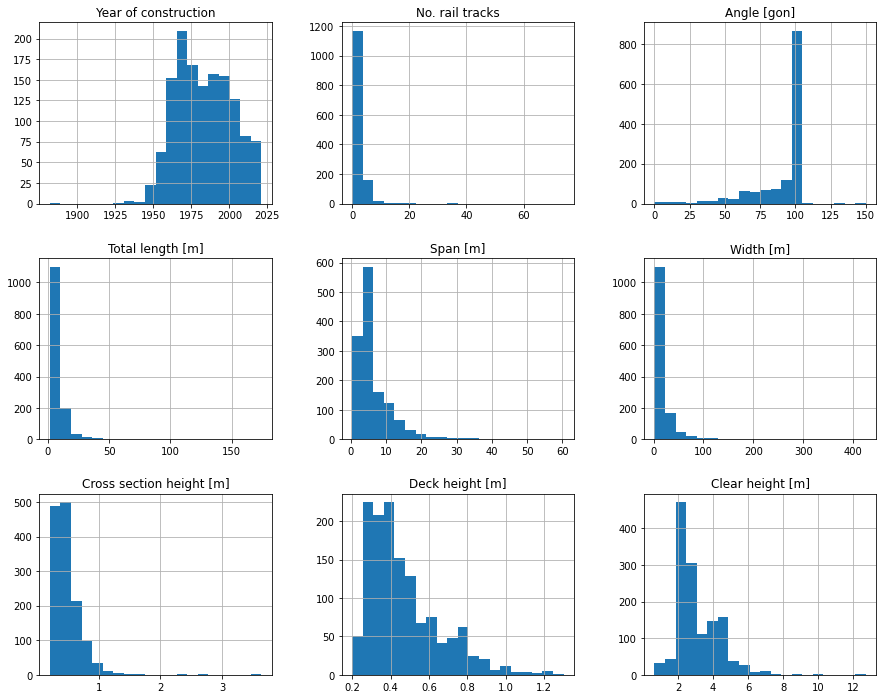

In [25]:
# Plot numerical parameters
columns_num = dataset.select_dtypes('float').columns 
print(columns_num)
columns_to_plot = ['Year of construction', 'No. rail tracks', 'Angle [gon]', 'Total length [m]', 'Span [m]', 'Width [m]', 'Cross section height [m]', 'Deck height [m]', 'Clear height [m]']

dataset.hist(column=columns_to_plot, bins=20, grid=True, figsize=[15,12], color='tab:blue')

C:\Users\isabe\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\isabe\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\isabe\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\isabe\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

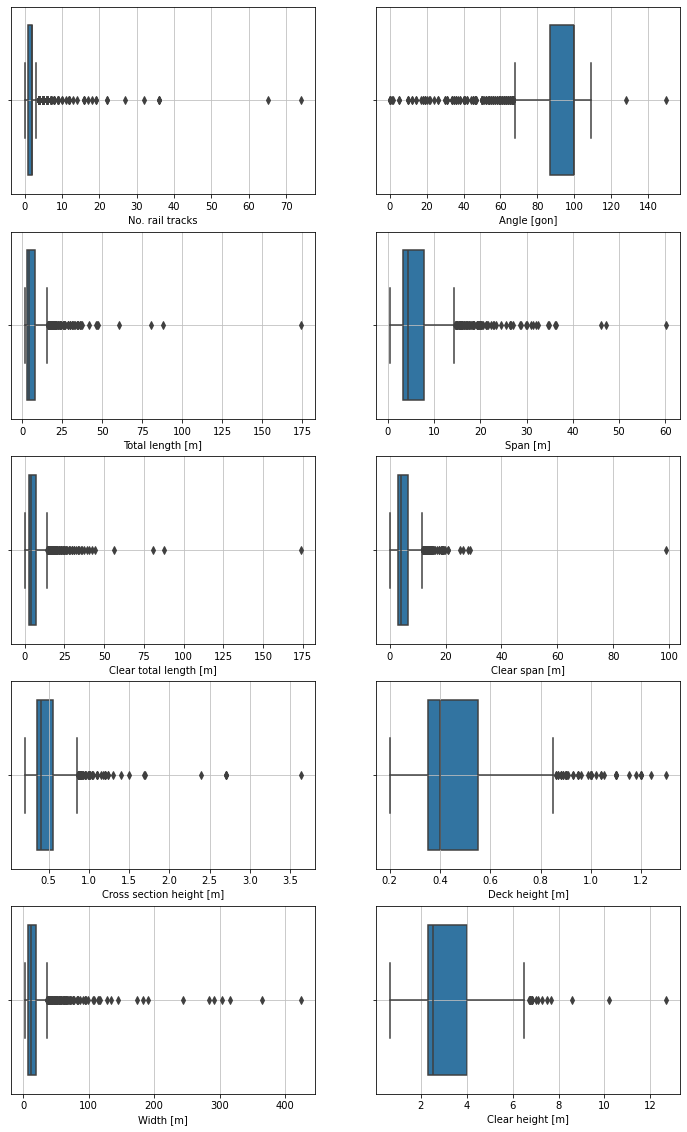

In [26]:
fig = plt.figure(figsize=[12,20])
gs = fig.add_gridspec(5, 2)

ax0 = fig.add_subplot(gs[0, 0])
ax0 = sns.boxplot(x='No. rail tracks', data = dataset)
ax0.grid(True, color='0.75')

ax1 = fig.add_subplot(gs[0, 1])
ax1 = sns.boxplot(x='Angle [gon]', data = dataset)
ax1.grid(True, color='0.75')

ax2 = fig.add_subplot(gs[1, 0])
ax2 = sns.boxplot(x='Total length [m]', data = dataset)
ax2.grid(True, color='0.75')

ax3 = fig.add_subplot(gs[1, 1])
ax3 = sns.boxplot(x='Span [m]', data = dataset)
ax3.grid(True, color='0.75')

ax4 = fig.add_subplot(gs[2, 0])
ax4 = sns.boxplot(x='Clear total length [m]', data = dataset)
ax4.grid(True, color='0.75')

ax5 = fig.add_subplot(gs[2, 1])
ax5 = sns.boxplot(x='Clear span [m]', data = dataset)
ax5.grid(True, color='0.75')

ax6 = fig.add_subplot(gs[3, 0])
ax6 = sns.boxplot(x='Cross section height [m]', data = dataset)
ax6.grid(True, color='0.75')

ax7 = fig.add_subplot(gs[3, 1])
ax7 = sns.boxplot(x='Deck height [m]', data = dataset)
ax7.grid(True, color='0.75')

ax8 = fig.add_subplot(gs[4, 0])
ax8 = sns.boxplot(x='Width [m]', data = dataset)
ax8.grid(True, color='0.75')

ax9 = fig.add_subplot(gs[4, 1])
ax9 = sns.boxplot(x='Clear height [m]', data = dataset)
ax9.grid(True, color='0.75')

Index(['Cross section', 'Function', 'Rehabilitation', 'Track bed',
       'Frame type', 'Rail load limit', 'Prestressing', 'No. spans', 'Sealing',
       'Protective layer', 'Precast elements', 'Transv. prestressing'],
      dtype='object')


C:\Users\isabe\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\isabe\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\isabe\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\isabe\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

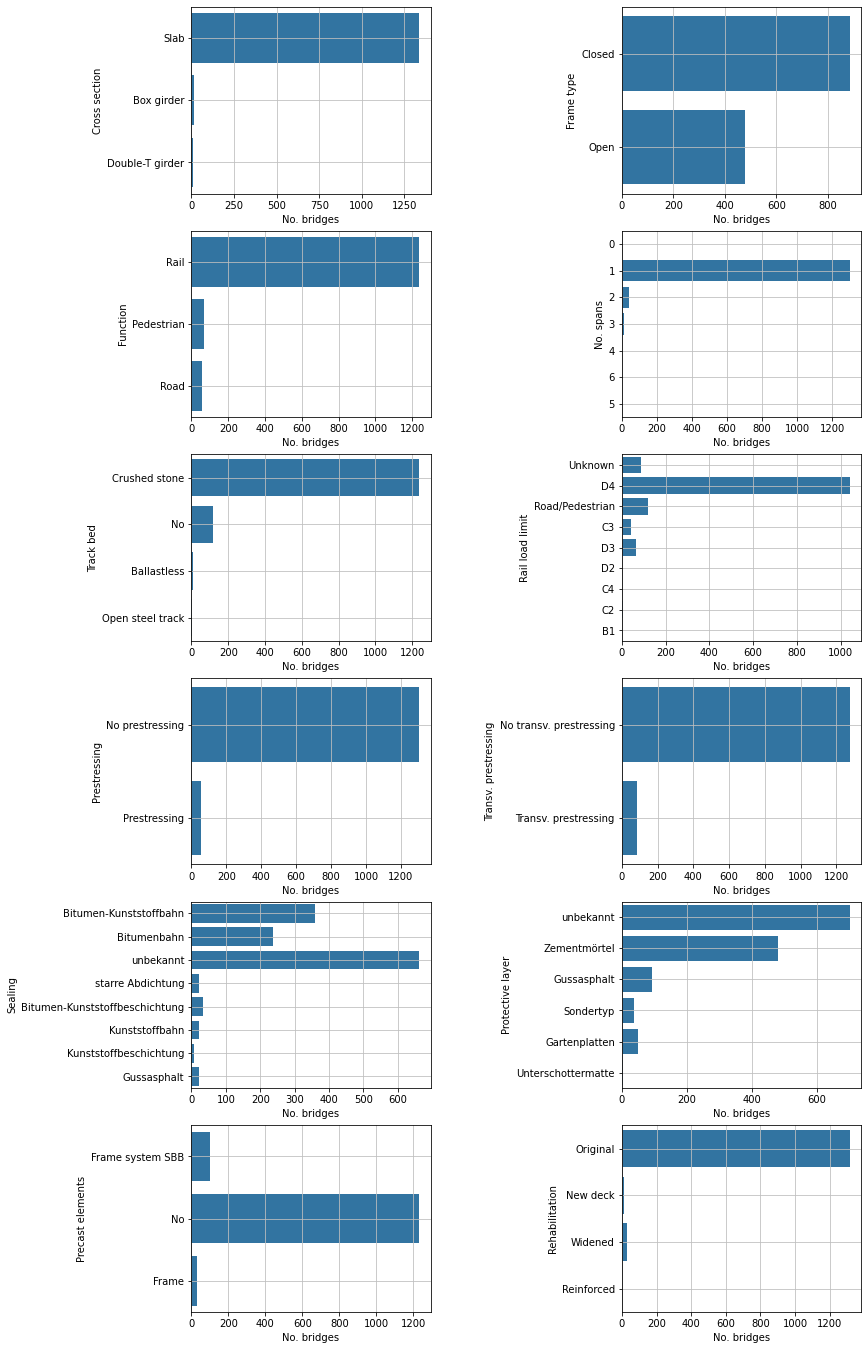

In [27]:
# Plot categorical parameters
columns_cat = dataset.select_dtypes('object').columns 
print(columns_cat)

fig = plt.figure(figsize=[12,24])
gs = fig.add_gridspec(6, 2, wspace=0.8)

ax0 = fig.add_subplot(gs[0, 0])
ax0 = sns.countplot(y='Cross section', data=dataset, color='tab:blue')
ax0.set_xlabel('No. bridges')
ax0.grid(True, color='0.75')

ax1 = fig.add_subplot(gs[0, 1])
ax1 = sns.countplot(y='Frame type', data=dataset, color='tab:blue')
ax1.set_xlabel('No. bridges')
ax1.grid(True, color='0.75')

ax2 = fig.add_subplot(gs[1, 0])
ax2 = sns.countplot(y='Function', data=dataset, color='tab:blue')
ax2.set_xlabel('No. bridges')
ax2.grid(True, color='0.75')

ax3 = fig.add_subplot(gs[1, 1])
ax3 = sns.countplot(y='No. spans', data=dataset, color='tab:blue')
ax3.set_xlabel('No. bridges')
ax3.grid(True, color='0.75')

ax4 = fig.add_subplot(gs[2, 0])
ax4 = sns.countplot(y='Track bed', data=dataset, color='tab:blue')
ax4.set_xlabel('No. bridges')
ax4.grid(True, color='0.75')

ax5 = fig.add_subplot(gs[2, 1])
ax5 = sns.countplot(y='Rail load limit', data=dataset, color='tab:blue')
ax5.set_xlabel('No. bridges')
ax5.grid(True, color='0.75')

ax6 = fig.add_subplot(gs[3, 0])
ax6 = sns.countplot(y='Prestressing', data=dataset, color='tab:blue')
ax6.set_xlabel('No. bridges')
ax6.grid(True, color='0.75')

ax7 = fig.add_subplot(gs[3, 1])
ax7 = sns.countplot(y='Transv. prestressing', data=dataset, color='tab:blue')
ax7.set_xlabel('No. bridges')
ax7.grid(True, color='0.75')

ax8 = fig.add_subplot(gs[4, 0])
ax8 = sns.countplot(y='Sealing', data=dataset, color='tab:blue')
ax8.set_xlabel('No. bridges')
ax8.grid(True, color='0.75')

ax9 = fig.add_subplot(gs[4, 1])
ax9 = sns.countplot(y='Protective layer', data=dataset, color='tab:blue')
ax9.set_xlabel('No. bridges')
ax9.grid(True, color='0.75')

ax10 = fig.add_subplot(gs[5, 0])
ax10 = sns.countplot(y='Precast elements', data=dataset, color='tab:blue')
ax10.set_xlabel('No. bridges')
ax10.grid(True, color='0.75')

ax11 = fig.add_subplot(gs[5, 1])
ax11 = sns.countplot(y='Rehabilitation', data=dataset, color='tab:blue')
ax11.set_xlabel('No. bridges')
ax11.grid(True, color='0.75')

C:\Users\isabe\AppData\Local\Temp\ipykernel_1532\2906545122.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12,8))


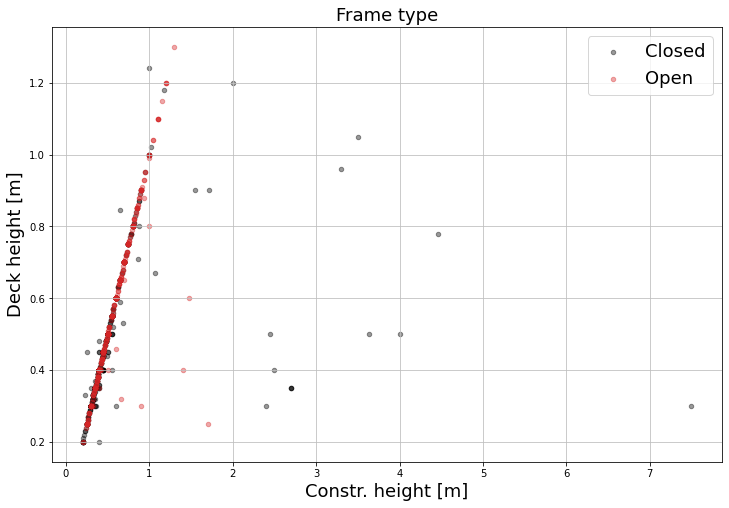

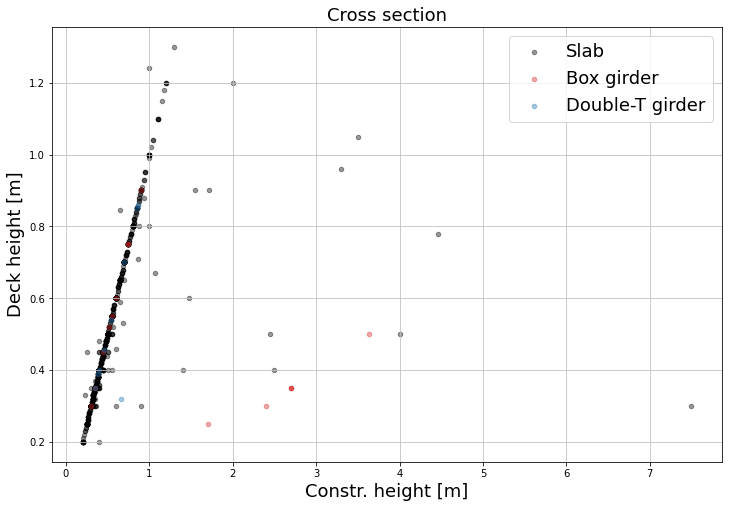

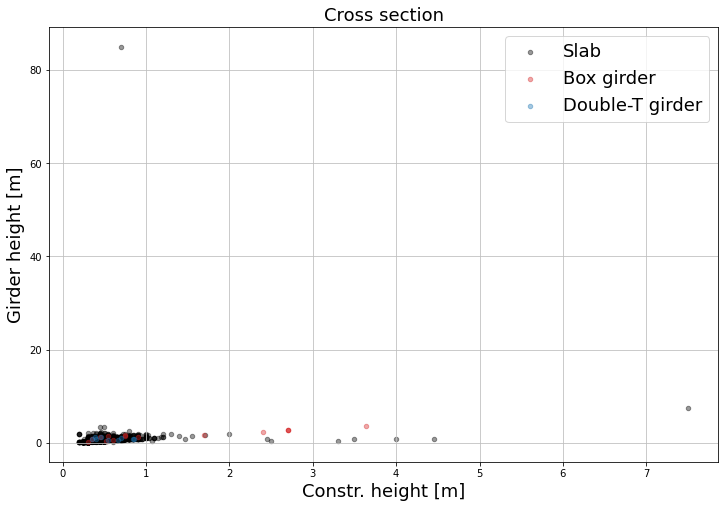

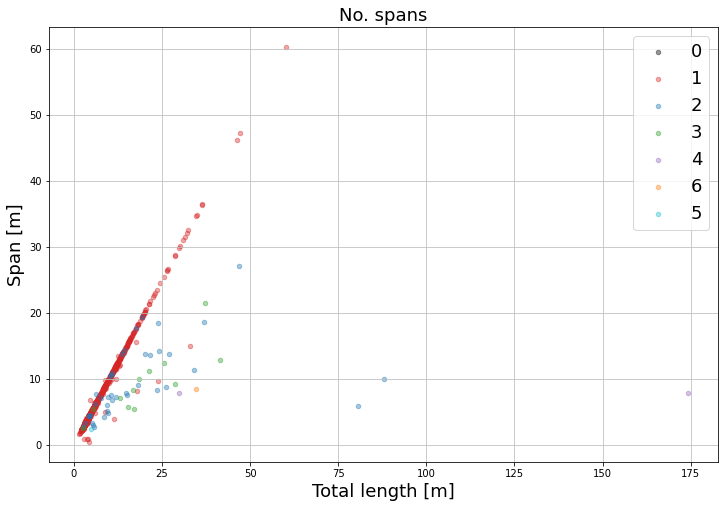

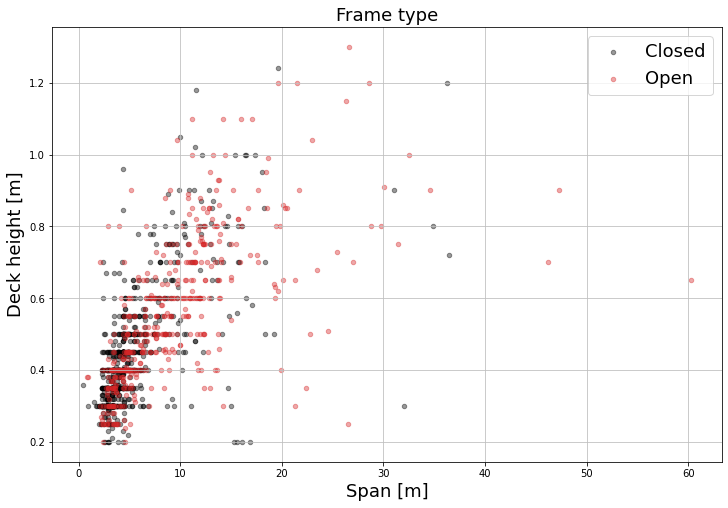

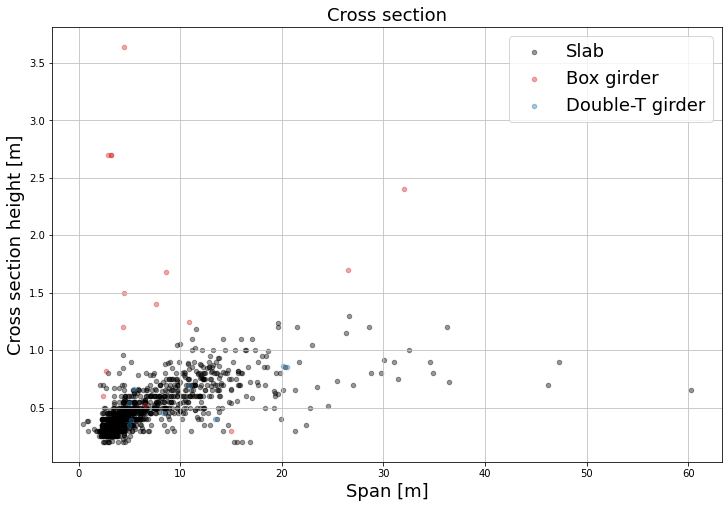

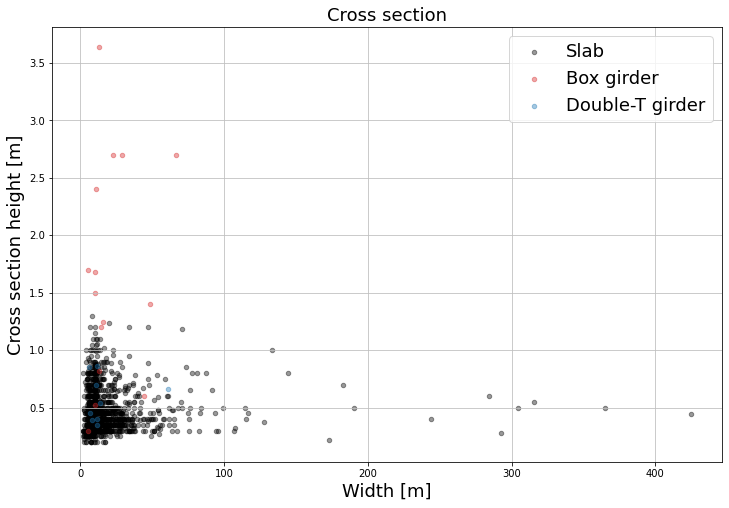

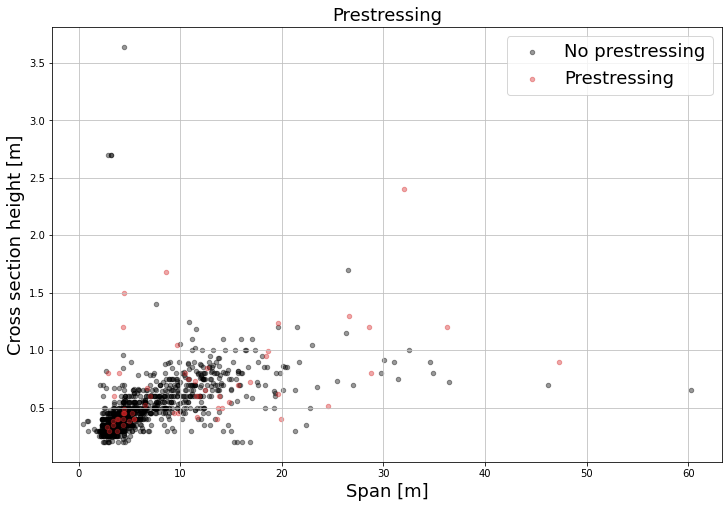

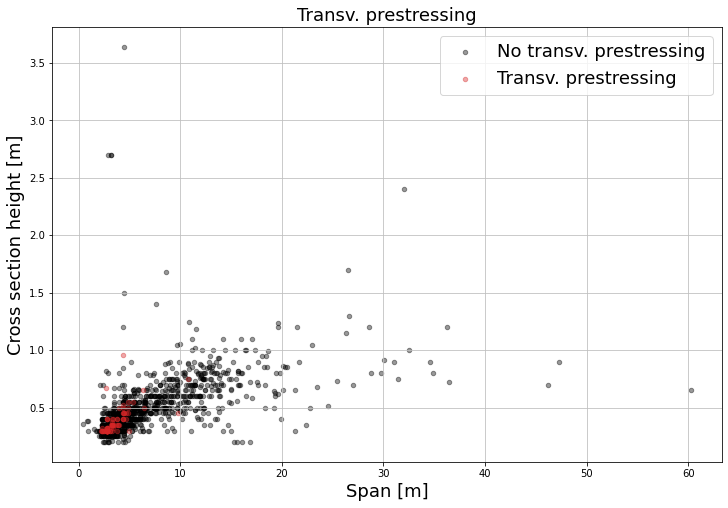

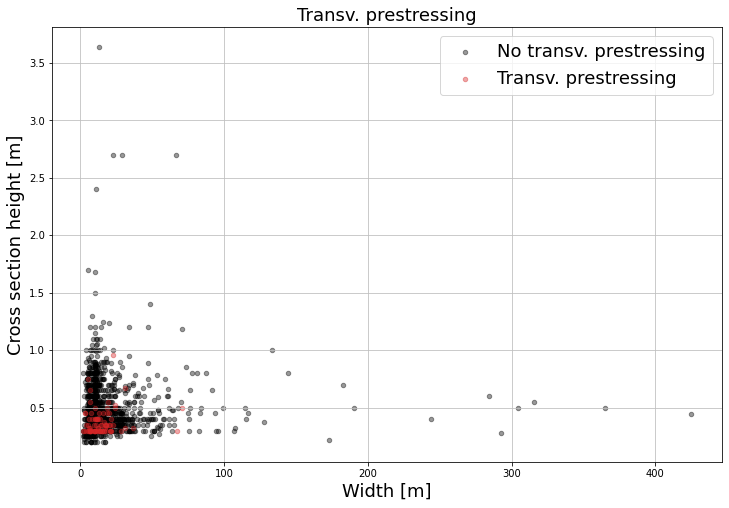

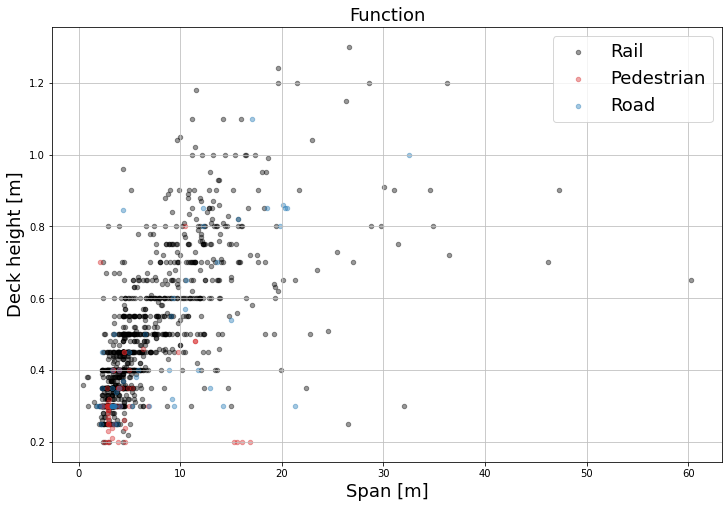

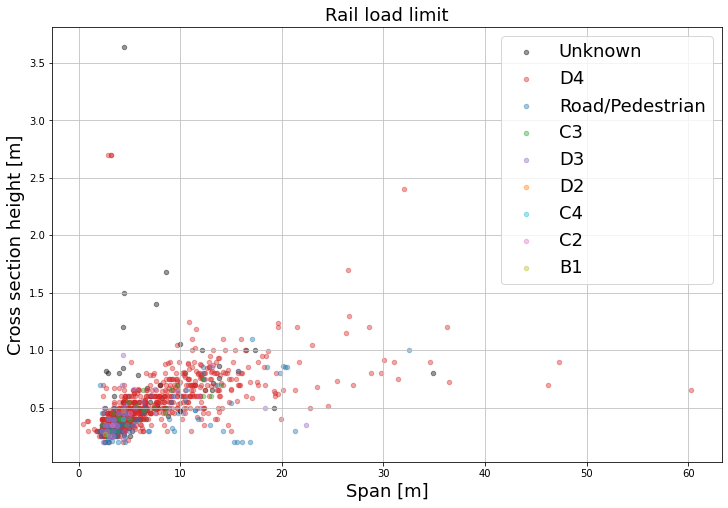

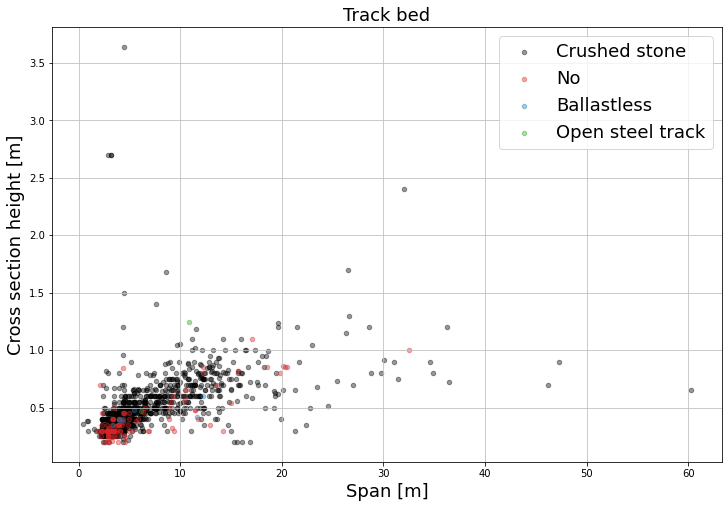

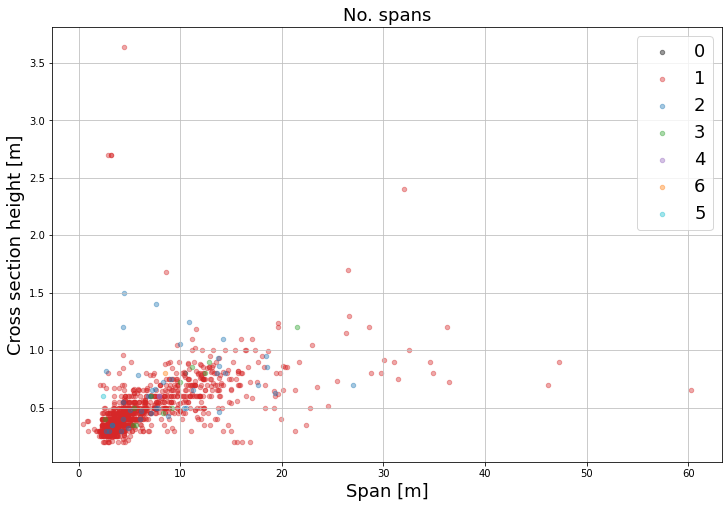

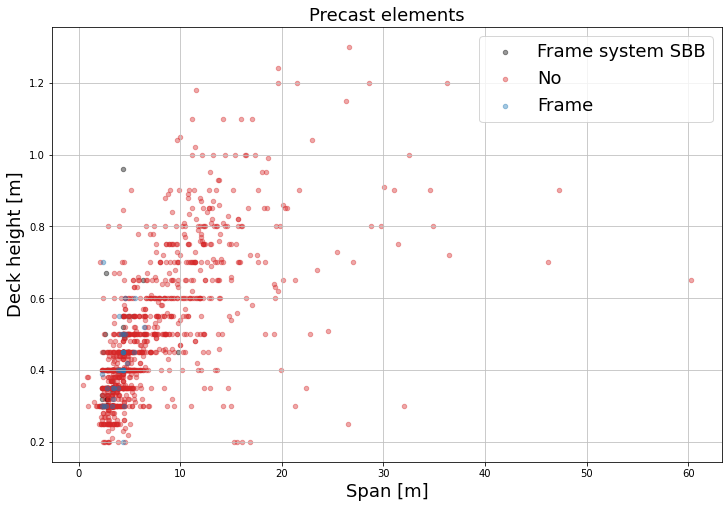

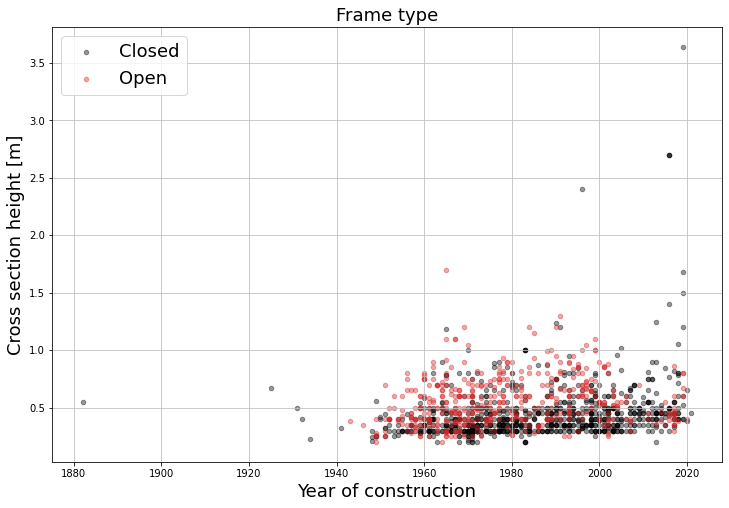

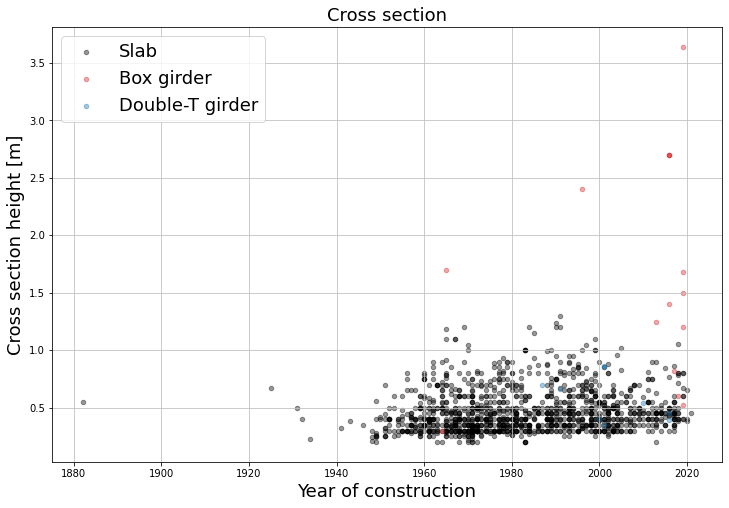

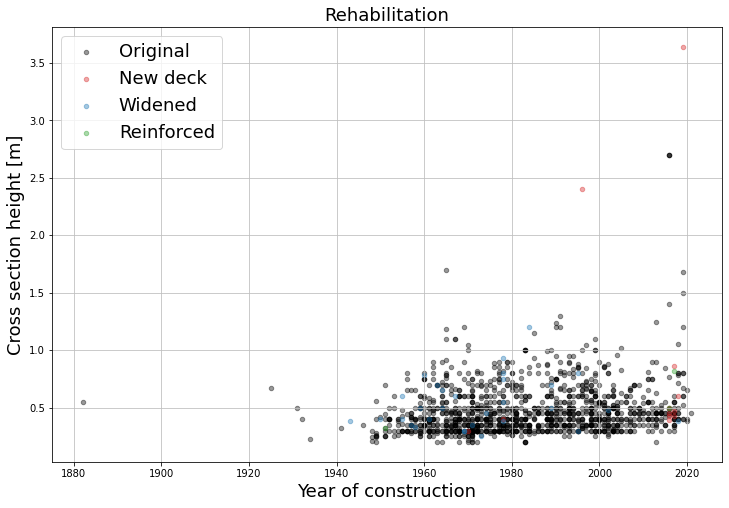

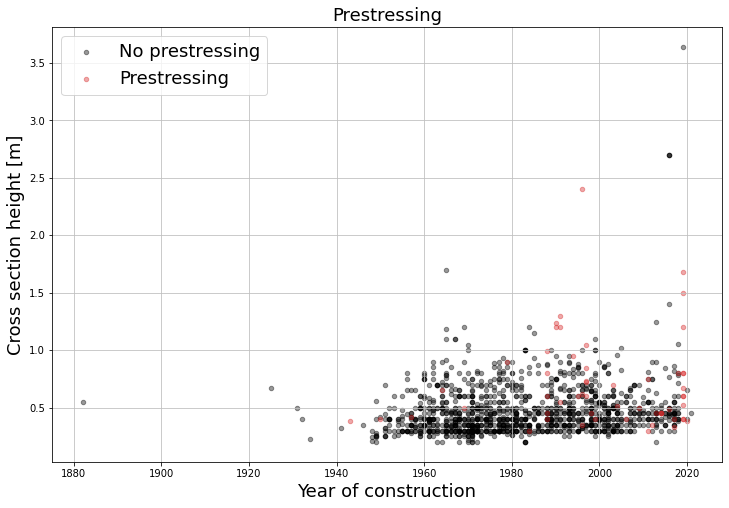

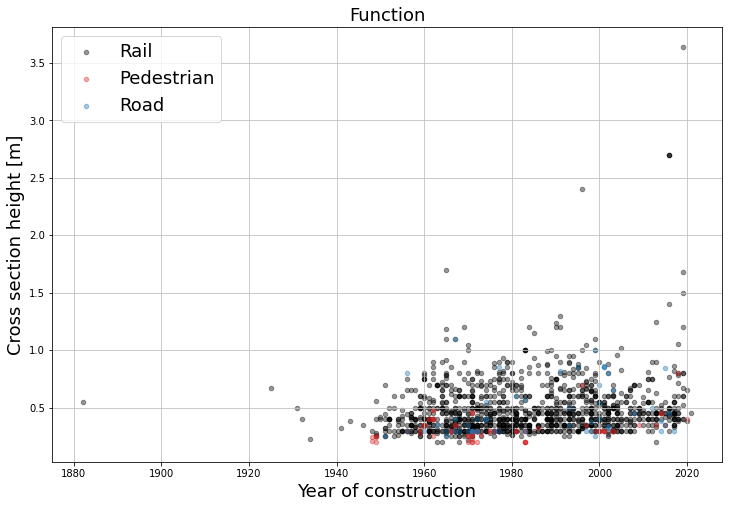

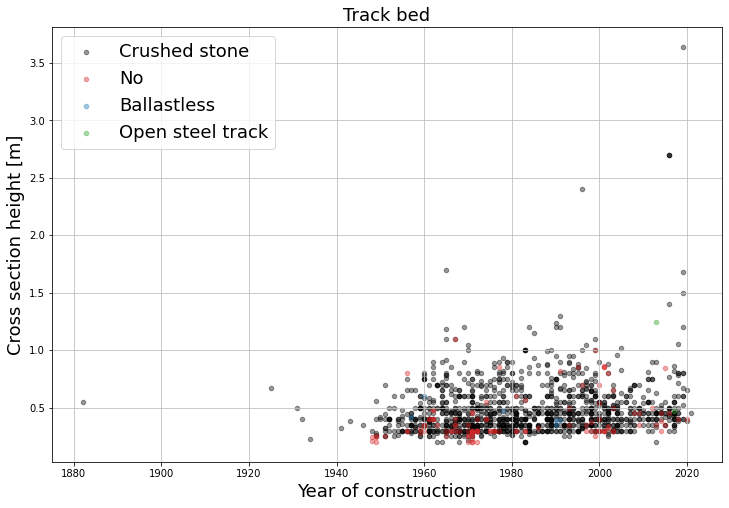

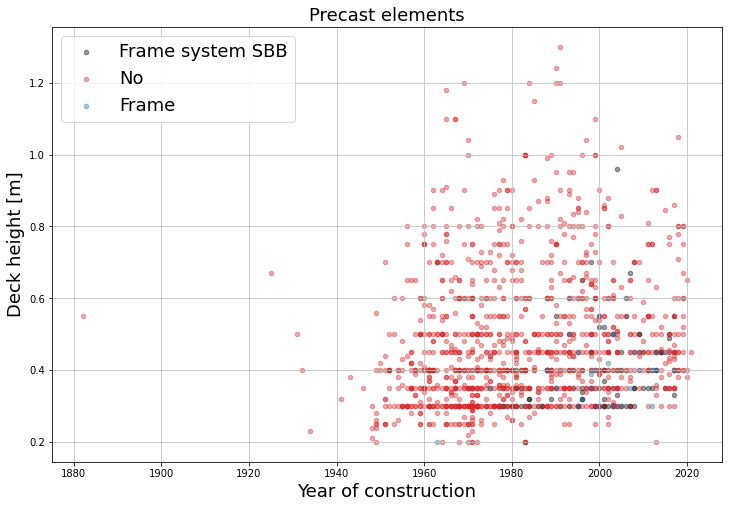

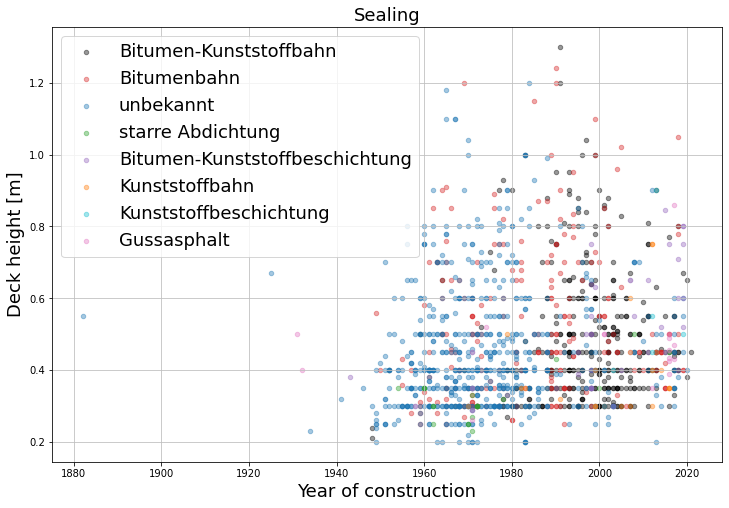

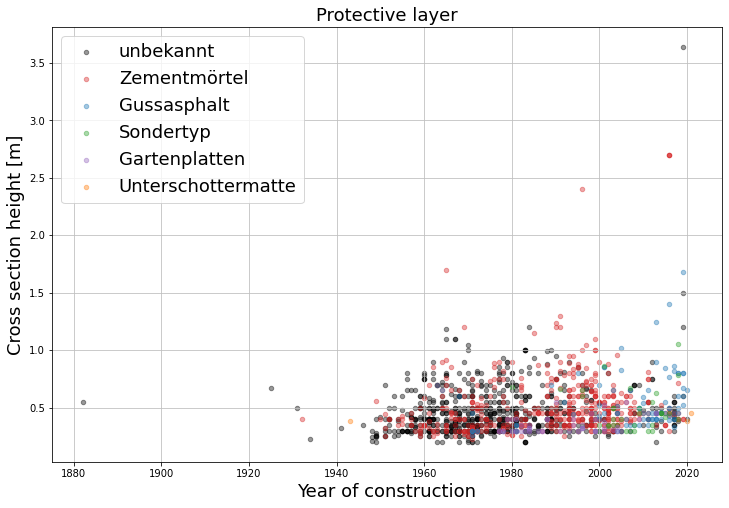

In [29]:
# Plot relationships between parameters
markers = ['*', 's', '<', 'o', 'X', '8', 'p', 'h', 'H', 'D', 'd', 'P']
colors = ['black','tab:red','tab:blue','tab:green','tab:purple','tab:orange','tab:cyan','tab:pink','tab:olive','tab:brown','tab:gray']

# type_plot_2D()
def type_plot_2D(dataset, param_x, param_y, param_type):
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot() #aspect='equal'

    types = dataset.loc[:,param_type].unique()

    for i,j in enumerate(types):
        index = dataset.index[dataset.loc[:,param_type]==j]
        x = dataset.loc[index,param_x]
        y = dataset.loc[index,param_y]
        ax.scatter(x, y, c=colors[i], alpha=0.4, marker='.', s=80, label=types[i])

    ax.set_xlabel(param_x, fontsize=18)
    ax.set_ylabel(param_y, fontsize=18)
    ax.grid(True, color='0.75')
    plt.legend(fontsize=18)
    plt.title(param_type,fontsize=18)
# end: type_plot_2D()

# Für geschlossene Rahmen sollte die Konstr-H der FB-Stärke entsprechen --> nicht immer der Fall
type_plot_2D(dataset, 'Constr. height [m]', 'Deck height [m]', 'Frame type')
# Für Typ Betonplatte sollte die Konstr-H der FB-Stärke entsprechen --> nicht immer der Fall
type_plot_2D(dataset, 'Constr. height [m]', 'Deck height [m]', 'Cross section')
# Für Typ Beton-Hohlkasten sollte die Konstr-H der Hauptträger-H entsprechen --> nicht immer der Fall
type_plot_2D(dataset, 'Constr. height [m]', 'Girder height [m]', 'Cross section')
# 'Querschnitts-H' verwenden
# Typ Betonplatte: FB-Stärke
# Typ Beton-Hohlkasten: Hauptträger-H
# Typ Beton-Plattenbalken: Konstruktions-H

# Für einfeldrige Brücken sollte die Gesamtlänge der Stützweite entsprechen --> nicht immer der Fall
type_plot_2D(dataset, 'Total length [m]', 'Span [m]', 'No. spans')
# Für einfeldrige + rechtwinklige! Brücken sollte die Gesamtlänge im Licht der Lichten Weite entsprechen --> nicht immer der Fall 
# dataset = dataset[(dataset['Winkel']==100)]
# type_plot_2D(dataset, 'Gesamtlänge im Licht', 'Lichte Weite', 'Felder')
# 'Gesamtlänge' und 'Stützweite' verwenden (relevant für Dimensionierung)

type_plot_2D(dataset, 'Span [m]', 'Deck height [m]', 'Frame type')
type_plot_2D(dataset, 'Span [m]', 'Cross section height [m]', 'Cross section')
type_plot_2D(dataset, 'Width [m]', 'Cross section height [m]', 'Cross section')
type_plot_2D(dataset, 'Span [m]', 'Cross section height [m]', 'Prestressing')
type_plot_2D(dataset, 'Span [m]', 'Cross section height [m]', 'Transv. prestressing')
type_plot_2D(dataset, 'Width [m]', 'Cross section height [m]', 'Transv. prestressing')
type_plot_2D(dataset, 'Span [m]', 'Deck height [m]', 'Function')
type_plot_2D(dataset, 'Span [m]', 'Cross section height [m]', 'Rail load limit')
type_plot_2D(dataset, 'Span [m]', 'Cross section height [m]', 'Track bed')
type_plot_2D(dataset, 'Span [m]', 'Cross section height [m]', 'No. spans')
type_plot_2D(dataset, 'Span [m]', 'Deck height [m]', 'Precast elements')

# type_plot_2D(dataset, 'Stützweite', 'Abdichtung', 'Typ')
# type_plot_2D(dataset, 'Stützweite', 'Abdichtung', 'Benutzung oben')
# type_plot_2D(dataset, 'Stützweite', 'Abdichtung', 'Gleisbettung')
# type_plot_2D(dataset, 'Stützweite', 'Abdichtung', 'Lastbeschränkung Bahnbrücke')
# type_plot_2D(dataset, 'Stützweite', 'Abdichtung', 'Fertigelemente')

# type_plot_2D(dataset, 'Stützweite', 'Schutz', 'Typ')
# type_plot_2D(dataset, 'Stützweite', 'Schutz', 'Benutzung oben')
# type_plot_2D(dataset, 'Stützweite', 'Schutz', 'Gleisbettung')
# type_plot_2D(dataset, 'Stützweite', 'Schutz', 'Lastbeschränkung Bahnbrücke')
# type_plot_2D(dataset, 'Stützweite', 'Schutz', 'Fertigelemente')

type_plot_2D(dataset, 'Year of construction', 'Cross section height [m]', 'Frame type')
type_plot_2D(dataset, 'Year of construction', 'Cross section height [m]', 'Cross section')
type_plot_2D(dataset, 'Year of construction', 'Cross section height [m]', 'Rehabilitation')
type_plot_2D(dataset, 'Year of construction', 'Cross section height [m]', 'Prestressing')
type_plot_2D(dataset, 'Year of construction', 'Cross section height [m]', 'Function')
type_plot_2D(dataset, 'Year of construction', 'Cross section height [m]', 'Track bed')
type_plot_2D(dataset, 'Year of construction', 'Deck height [m]', 'Precast elements')
type_plot_2D(dataset, 'Year of construction', 'Deck height [m]', 'Sealing')
type_plot_2D(dataset, 'Year of construction', 'Cross section height [m]', 'Protective layer')

## Preprocessing: Data completion with kNN

In [89]:
# Impute category 'Unknown' in 'Rail load limit' using kNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

rows_to_impute = dataset.index[(dataset['Rail load limit']=='Unknown')] 
print(rows_to_impute)
rows_known = dataset.index[(dataset['Rail load limit']!='Unknown')] 
print(rows_known)

label = dataset['Rail load limit']
data = dataset.drop(columns=['Rail load limit','Sealing','Protective layer','Rehabilitation'])
data = pd.get_dummies(data,drop_first=False) #encode categorical data  

X = data.loc[rows_known,:] #data to fit
print('Rail load limit known: ',X.shape)
y = label.loc[rows_known] #label to fit
X_pred = data.loc[rows_to_impute,:] #data to predict
print('Rail load limit unknown: ',X_pred.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #split 
imputer = KNeighborsClassifier().fit(X_train,y_train) #fit
y_test_pred = imputer.predict(X_test) #evalaute
print('Accuracy: ',accuracy_score(y_test,y_test_pred))
y_pred = imputer.predict(X_pred) #predict 
print(pred)
dataset.loc[rows_to_impute,'Rail load limit'] = y_pred #replace 

Index([   3,    9,   19,   24,   26,   34,   44,   65,   66,  101,  123,  127,
        131,  134,  150,  172,  193,  205,  245,  252,  253,  256,  270,  284,
        320,  321,  331,  342,  348,  390,  393,  408,  426,  435,  451,  495,
        504,  521,  543,  562,  564,  591,  598,  601,  605,  631,  704,  722,
        725,  763,  800,  838,  882,  891,  892,  901,  910,  920,  934, 1014,
       1028, 1030, 1055, 1061, 1067, 1083, 1085, 1090, 1098, 1116, 1117, 1118,
       1165, 1202, 1226, 1230, 1244, 1247, 1303, 1352, 1381, 1391, 1468, 1474,
       1482, 1483, 1491, 1494],
      dtype='int64')
Index([   5,    7,   10,   11,   12,   13,   14,   15,   16,   17,
       ...
       1479, 1480, 1481, 1484, 1485, 1486, 1487, 1488, 1489, 1497],
      dtype='int64', length=1273)
Rail load limit known:  (1273, 39)
Rail load limit unknown:  (88, 39)
Accuracy:  0.8274509803921568
['D4' 'D4' 'D4' 'D4' 'D4' 'D4' 'D4' 'D4' 'D4' 'D4' 'D4' 'D4' 'D4' 'D4'
 'D4' 'D4' 'D4' 'D4' 'D4' 'D4' 'D4' 'D4' 'D

In [90]:
# Export 
dataset.to_csv('SBB_StahlbetonRahmenBrücken_Auswahl.csv', sep=";")

In [ ]:
# Same for 'Sealing' and 'Protective layer'?